### <b>3.4 MODELATGE PREDICTIU</b>

# <b>3.4.1 Model base: GLM/GAM</b>

In [5]:
# =====================================================================
# 3.4.1 MODEL BASE: GLM PER A FREQÜÈNCIA I SEVERITAT
# =====================================================================
# En aquest script munto els meus models base amb GLM:
#   - Freqüència: Binomial (probabilitat de sinistre anual)
#   - Severitat : Gamma amb link log (cost del sinistre condicionat a sinistre)
#
# La idea és tenir un baseline coherent, transparent i repetible:
#   - Carrego datasets ja tallats temporalment (train 2015–2017, test 2018)
#   - Defineixo un espai de predictors "manual" (triats per mi)
#   - Dins d’aquest espai, faig una selecció automàtica simple (greedy)
#     per reduir dimensionalitat sense sortir-me del que considero explicable
#   - Ajusto els GLM i avaluo mètriques bàsiques al test
# =====================================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import (
    roc_auc_score,
    brier_score_loss,
    log_loss,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from math import sqrt
from statsmodels.genmod.families.links import Log

# ---------------------------------------------------------------------
# 1. Càrrega de dades
# ---------------------------------------------------------------------
# Aquí carrego els datasets ja preparats a la carpeta data/model.
# Són els que han sortit del pipeline d'enginyeria de variables i split temporal.
base_model_path = "data/model"

FREQ_TRAIN_PATH = f"{base_model_path}/freq_glm_train.csv"
FREQ_TEST_PATH  = f"{base_model_path}/freq_glm_test.csv"

SEV_TRAIN_PATH  = f"{base_model_path}/sev_train.csv"
SEV_TEST_PATH   = f"{base_model_path}/sev_test.csv"

freq_train = pd.read_csv(FREQ_TRAIN_PATH)
freq_test  = pd.read_csv(FREQ_TEST_PATH)
sev_train  = pd.read_csv(SEV_TRAIN_PATH)
sev_test   = pd.read_csv(SEV_TEST_PATH)

print("Freq GLM train/test:", freq_train.shape, freq_test.shape)
print("Severitat train/test:", sev_train.shape, sev_test.shape)

# ---------------------------------------------------------------------
# 2. Exclusions conceptuals
# ---------------------------------------------------------------------
# Defineixo els targets i quines columnes NO vull considerar predictors
# perquè són metadades (ID, any, split) o perquè serien leakage directament.
target_freq = "Has_claims_year"
target_sev  = "Cost_claims_year"

exclude_freq = ["ID", "Policy_year", "set_type"]
exclude_sev  = ["ID", "Policy_year", "set_type", "Has_claims_year", target_sev]

# =====================================================================
# 3. Predictors manuals definits per mi
# =====================================================================
# Aquí escric el meu "pool" de candidats. La selecció automàtica posterior
# NO sortirà d’aquest espai, perquè vull controlar interpretabilitat i coherència.
freq_predictors_manual = [
    "Licence_age",
    "Vehicle_age",
    "Policy_duration",
    "Power",
    "Seniority",
    "Type_risk_ord",
    "Area_1",
    "Type_fuel_D",
    "Type_fuel_Unknown",
    "Distribution_channel_1",
    "Second_driver_1",
    "Has_lapse_1",
    "Has_claims_history_1",
    "Value_to_power",
    "Premium_to_value",
]

sev_predictors_manual = [
    "Licence_age",
    "Vehicle_age",
    "Policy_duration",
    "Power",
    "Power_log",
    "Value_vehicle",
    "Value_vehicle_log",
    "Weight",
    "Type_risk_ord",
    "Area",
    "Premium",
    "Premium_to_value",
    "Power_x_Value_vehicle",
]

print("\n[FREQ] Predictors manuals:", freq_predictors_manual)
print("\n[SEV] Predictors manuals refined:", sev_predictors_manual)

# ---------------------------------------------------------------------
# 4. Funcions de selecció automàtica (només dins l'espai manual)
# ---------------------------------------------------------------------
def select_auto_predictors_from_manual(
    df: pd.DataFrame,
    target_col: str,
    manual_cols,
    max_vars: int,
    corr_threshold: float = 0.80,
):
    """
    Aquí faig una selecció greedy molt simple dins de l'espai manual:

    1) Em quedo només amb columnes manuals que:
       - existeixen al dataset
       - són numèriques de veritat
       - tenen més d’un valor (evito constants)

    2) Ordeno candidates per |correlació| amb el target (criteri ràpid i interpretable)

    3) Vaig afegint variables mentre:
       - no superi max_vars
       - no quedin massa correlacionades entre elles (|corr| < corr_threshold)

    Important:
    - Això NO és una selecció "òptima" ni un procediment inferencial,
      però em serveix per fer un baseline net sense sobrecarregar el GLM.
    """
    manual_numeric = [
        c for c in manual_cols
        if c in df.columns and pd.api.types.is_numeric_dtype(df[c]) and df[c].nunique() > 1
    ]

    if not manual_numeric:
        raise ValueError("No hi ha columnes manuals numèriques vàlides per a fer selecció auto.")

    # Correlació (absoluta) amb el target
    corrs = [(c, abs(df[c].corr(df[target_col]))) for c in manual_numeric]
    corrs = [c for c in corrs if not pd.isna(c[1])]
    corrs.sort(key=lambda x: x[1], reverse=True)

    selected = []
    for col, _ in corrs:
        if len(selected) >= max_vars:
            break

        ok = True
        for s in selected:
            cs_corr = df[[col, s]].corr().iloc[0, 1]
            if abs(cs_corr) >= corr_threshold:
                ok = False
                break

        if ok:
            selected.append(col)

    return selected

# =====================================================================
# 5. FREQ – Selecció auto (dins 15 manuals), màx 12 predictors
# =====================================================================
# Aplico la selecció greedy dins del pool manual de freq.
# Això em dona la llista final de predictors per al GLM binomial.
freq_predictors_auto = select_auto_predictors_from_manual(
    df=freq_train,
    target_col=target_freq,
    manual_cols=freq_predictors_manual,
    max_vars=12,
    corr_threshold=0.80,
)

freq_predictors_final = freq_predictors_auto

print("\n[FREQ] Predictors finals freq:", freq_predictors_final)
print("[FREQ] Nº predictors finals:", len(freq_predictors_final))

# Munto matrius X/y. Omplo NaN amb 0.0 perquè aquí vull que el model corri estable
# (les transformacions ja haurien d'haver resolt això, però ho faig per seguretat).
X_train_freq = sm.add_constant(freq_train[freq_predictors_final].fillna(0.0))
X_test_freq  = sm.add_constant(freq_test[freq_predictors_final].fillna(0.0))
y_train_freq = freq_train[target_freq].astype(int)
y_true_freq  = freq_test[target_freq].astype(int)

# Ajusto GLM Binomial (link logit per defecte en Binomial)
freq_glm = sm.GLM(y_train_freq, X_train_freq, family=sm.families.Binomial()).fit()

# Prediccions: asseguro que no hi ha 0/1 exactes per evitar problemes amb log-loss
freq_pred = freq_glm.predict(X_test_freq).clip(1e-15, 1 - 1e-15)

# Mètriques de classificació
auc_glm_freq     = roc_auc_score(y_true_freq, freq_pred)
brier_glm_freq   = brier_score_loss(y_true_freq, freq_pred)
logloss_glm_freq = log_loss(y_true_freq, freq_pred)

print("\n[Freq GLM] summary:")
print(freq_glm.summary())
print("\n[Freq GLM] test metrics:")
print(" AUC      :", auc_glm_freq)
print(" Brier   :", brier_glm_freq)
print(" Log-loss :", logloss_glm_freq)

# =====================================================================
# 6. SEV – Filtratge + selecció auto dins 13 manuals, màx 10 predictors
# =====================================================================
# En severitat treballo només amb sinistres positius (cost > 0).
# Si al dataset hi ha Has_claims_year, el faig servir per filtrar de forma explícita.
if "Has_claims_year" in sev_train.columns:
    sev_train_filtered = sev_train[
        (sev_train["Has_claims_year"] == 1) & (sev_train[target_sev] > 0)
    ].copy()
else:
    sev_train_filtered = sev_train[sev_train[target_sev] > 0].copy()

if "Has_claims_year" in sev_test.columns:
    sev_test_filtered = sev_test[
        (sev_test["Has_claims_year"] == 1) & (sev_test[target_sev] > 0)
    ].copy()
else:
    sev_test_filtered = sev_test[sev_test[target_sev] > 0].copy()

print("\n[SEV] Train/Test dims after filter:", sev_train_filtered.shape, sev_test_filtered.shape)

# Aquí capejo outliers del target al 99.5% sobre TRAIN.
# Ho faig per estabilitzar l'ajust del Gamma i evitar que uns pocs casos
# em dominin el fit del baseline.
q_cap = sev_train_filtered[target_sev].quantile(0.995)
sev_train_filtered[target_sev] = sev_train_filtered[target_sev].clip(upper=q_cap)

# Selecció auto dins del pool manual de severitat
sev_predictors_auto = select_auto_predictors_from_manual(
    df=sev_train_filtered,
    target_col=target_sev,
    manual_cols=sev_predictors_manual,
    max_vars=10,
    corr_threshold=0.80,
)

sev_predictors_final = sev_predictors_auto

print("\n[SEV] Predictors finals sev:", sev_predictors_final)
print("[SEV] Nº predictors finals:", len(sev_predictors_final))

# Munto X/y per severitat
X_train_sev = sm.add_constant(sev_train_filtered[sev_predictors_final].fillna(0.0))
X_test_sev  = sm.add_constant(sev_test_filtered[sev_predictors_final].fillna(0.0))
y_train_sev = sev_train_filtered[target_sev]
y_true_sev  = sev_test_filtered[target_sev]

# Ajusto GLM Gamma amb link log (molt típic en severitat actuarial)
sev_glm = sm.GLM(y_train_sev, X_train_sev, family=sm.families.Gamma(Log())).fit()

# Predicció de cost
sev_pred = sev_glm.predict(X_test_sev)

# Mètriques de regressió
mae_sev  = mean_absolute_error(y_true_sev, sev_pred)
rmse_sev = sqrt(mean_squared_error(y_true_sev, sev_pred))
r2_sev   = r2_score(y_true_sev, sev_pred)

print("\n[Severitat GLM] summary:")
print(sev_glm.summary())
print("\n[Severitat GLM] test metrics:")
print(" MAE  :", mae_sev)
print(" RMSE :", rmse_sev)
print(" R²   :", r2_sev)

# =====================================================================
# 7. RESUM FINAL METRIC
# =====================================================================
# Aquí deixo un diccionari amb mètriques per tenir-les ben agrupades i
# poder-les comparar després amb models més avançats.
metrics_glm_baseline = {
    "freq_glm_binomial_auc":     auc_glm_freq,
    "freq_glm_binomial_brier":   brier_glm_freq,
    "freq_glm_binomial_logloss": logloss_glm_freq,
    "sev_glm_gamma_mae":         mae_sev,
    "sev_glm_gamma_rmse":        rmse_sev,
    "sev_glm_gamma_r2":          r2_sev,
}

print("\n===== FINAL GLM BASELINE METRICS =====")
for k, v in metrics_glm_baseline.items():
    print(f"{k}: {v}")


Freq GLM train/test: (69740, 39) (35815, 39)
Severitat train/test: (16259, 36) (3387, 36)

[FREQ] Predictors manuals: ['Licence_age', 'Vehicle_age', 'Policy_duration', 'Power', 'Seniority', 'Type_risk_ord', 'Area_1', 'Type_fuel_D', 'Type_fuel_Unknown', 'Distribution_channel_1', 'Second_driver_1', 'Has_lapse_1', 'Has_claims_history_1', 'Value_to_power', 'Premium_to_value']

[SEV] Predictors manuals refined: ['Licence_age', 'Vehicle_age', 'Policy_duration', 'Power', 'Power_log', 'Value_vehicle', 'Value_vehicle_log', 'Weight', 'Type_risk_ord', 'Area', 'Premium', 'Premium_to_value', 'Power_x_Value_vehicle']

[FREQ] Predictors finals freq: ['Has_claims_history_1', 'Power', 'Seniority', 'Type_fuel_D', 'Licence_age', 'Second_driver_1', 'Type_risk_ord', 'Premium_to_value', 'Distribution_channel_1', 'Vehicle_age', 'Type_fuel_Unknown', 'Has_lapse_1']
[FREQ] Nº predictors finals: 12

[Freq GLM] summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable: 

### <b>3.4.2. Models avançats (ensemble i no lineals)</b>

In [8]:
# ====================================================
# 3.4.2 MODELS AVANÇATS (ENSEMBLES I NO LINEALS)
# ====================================================
# En aquest script entreno models més flexibles que el GLM baseline (3.4.1):
#   - FREQÜÈNCIA (classificació): RF, Gradient Boosting, i opcionalment XGBoost / LightGBM
#   - SEVERITAT (regressió): opcionalment XGBoostRegressor / LightGBMRegressor
#   - RÀTIO (benchmark): un regressor simple si tinc el dataset de ràtio disponible
#   - ANN (freqüència): una xarxa neuronal molt bàsica com a contrast no lineal
#
# La meva prioritat aquí és mantenir el pipeline AUDITABLE i sense leakage:
#   - Split temporal ja aplicat (train 2015–2017, test 2018)
#   - Excloc metadades (ID, Policy_year, set_type)
#   - Excloc targets i derivades "ex post" quan toca
#   - Alineo train/test perquè els ensembles necessiten el mateix esquema de features
#
# Nota important (coherència amb el text inicial del script):
#   - En severitat, NO vull que Has_claims_year entri mai com a feature.
#     Encara que fos constant després del filtre, prefereixo deixar-ho explícit
#     per higiene estadística i per auditoria.
#   - A més, faig una exclusió defensiva de variables clarament ex post
#     si mai s’haguessin colat al dataset (sense inventar res: només les trec si hi són).
# ====================================================

import pandas as pd
import numpy as np
from math import sqrt
import time

from sklearn.metrics import (
    roc_auc_score,
    brier_score_loss,
    log_loss,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    average_precision_score
)

from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    GradientBoostingRegressor,
)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ---------------------------------------------------------------------
# 1) RANDOM STATE GLOBAL (reproductibilitat)
# ---------------------------------------------------------------------
# Fixar llavors em permet replicar resultats i comparar models de forma justa.
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ---------------------------------------------------------------------
# 2) CÀRREGA DATASETS
# ---------------------------------------------------------------------
# Carrego els datasets ja separats temporalment (train/test) des de data/model.
# Això és clau perquè aquí no hi hagi cap barreja d’anys.
FREQ_GBM_TRAIN_PATH = "data/model/freq_gbm_train.csv"
FREQ_GBM_TEST_PATH  = "data/model/freq_gbm_test.csv"

SEV_TRAIN_PATH = "data/model/sev_train.csv"
SEV_TEST_PATH  = "data/model/sev_test.csv"

RATIO_TRAIN_PATH = "data/model/ratio_train.csv"
RATIO_TEST_PATH  = "data/model/ratio_test.csv"

freq_gbm_train = pd.read_csv(FREQ_GBM_TRAIN_PATH)
freq_gbm_test  = pd.read_csv(FREQ_GBM_TEST_PATH)

sev_train = pd.read_csv(SEV_TRAIN_PATH)
sev_test  = pd.read_csv(SEV_TEST_PATH)

# El model de ràtio és opcional: si no tinc fitxers, ho salto sense trencar res.
try:
    ratio_train = pd.read_csv(RATIO_TRAIN_PATH)
    ratio_test  = pd.read_csv(RATIO_TEST_PATH)
    RATIO_AVAILABLE = True
except FileNotFoundError:
    ratio_train = None
    ratio_test  = None
    RATIO_AVAILABLE = False
    print("Fitxers de ratio no trobats → el model directe de ràtio s'ometrà.")

print("Freq GBM train/test:", freq_gbm_train.shape, freq_gbm_test.shape)
print("Severitat train/test:", sev_train.shape, sev_test.shape)
if RATIO_AVAILABLE:
    print("Ràtio train/test:", ratio_train.shape, ratio_test.shape)

# ---------------------------------------------------------------------
# 3) IMPORTACIÓ SEGURA DE XGBOOST I LIGHTGBM
# ---------------------------------------------------------------------
# Aquí faig imports "defensius": si no estan instal·lats, segueixo igual
# amb RF/GB sklearn, i ho deixo reflectit per consola.
try:
    from xgboost import XGBClassifier, XGBRegressor
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False
    print("XGBoost no instal·lat → s'ometen models XGB.")

try:
    from lightgbm import LGBMClassifier, LGBMRegressor
    LGBM_AVAILABLE = True
except ImportError:
    LGBM_AVAILABLE = False
    print("LightGBM no instal·lat → s'ometen models LGBM.")

# ---------------------------------------------------------------------
# 4) FUNCIONS AUXILIARS
# ---------------------------------------------------------------------
def align_train_test(X_train: pd.DataFrame, X_test: pd.DataFrame):
    """
    Alineo X_train i X_test perquè tinguin:
      - només columnes numèriques
      - exactament el mateix set de columnes i en el mateix ordre
      - NaN/Inf sanejats -> 0.0

    Per què ho faig?
      - En GBDT (XGB/LGBM) i fins i tot en RF/GB, vull evitar errors
        per desajustos de features entre train i test.
      - Si alguna columna no existeix a test (per un OHE/TE estrany),
        la creo amb zeros, que és una imputació neutral.
    """
    X_train_num = X_train.select_dtypes(include=[np.number]).copy()
    X_test_num  = X_test.select_dtypes(include=[np.number]).copy()

    train_cols = X_train_num.columns.tolist()
    X_test_num = X_test_num.reindex(columns=train_cols, fill_value=0.0)

    X_train_num = X_train_num.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    X_test_num  = X_test_num.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    return X_train_num, X_test_num


def prepare_xy_class_freq(df: pd.DataFrame, target: str = "Has_claims_year"):
    """
    Preparo X i y per al model de FREQÜÈNCIA (classificació binària).

    Dataset freq_gbm_*:
      - target: Has_claims_year
      - Excloc metadades que no poden entrar al model:
          * ID (identificador)
          * Policy_year (any, és variable tècnica del split)
          * set_type (etiqueta de split)
    """
    if target not in df.columns:
        raise ValueError(f"Falta la columna target '{target}' al dataset de freqüència.")

    exclude = [
        target,
        "ID",
        "Policy_year",
        "set_type",
    ]

    X = df.drop(columns=exclude)
    y = df[target].astype(int)

    return X, y


def prepare_xy_severity(df: pd.DataFrame, target: str = "Cost_claims_year"):
    """
    Preparo X i y per al model de SEVERITAT (regressió).

    Idees clau que vull preservar:
      - Treballo només amb cost > 0 (Gamma/log o models de cost no tenen sentit amb 0)
      - Excloc Has_claims_year si existeix (no vull que entri com a predictor)
      - Excloc targets i derivades directes del target (log/cap del cost)
      - Excloc també possibles variables ex post si mai s’haguessin colat
        (p.ex. N_claims_year o similars) → però només si existeixen al df.
    """
    if target not in df.columns:
        raise ValueError(f"Falta la columna target '{target}' al dataset de severitat.")

    # Em quedo amb costos estrictament positius
    df = df[df[target] > 0].copy()

    # Exclusions base (targets, metadades i derivades del target)
    exclude = [
        target,
        "ID",
        "Policy_year",
        "set_type",
        "Cost_claims_year_log",
        "Cost_claims_year_cap",
        "Has_claims_year",  # IMPORTANT: encara que fos constant, no vull que entri
    ]

    # Exclusions defensives anti-leakage (només trec les que realment existeixin)
    # Aquest bloc em protegeix si algun dia al pipeline s'hi cola alguna variable ex post.
    ex_post_candidates = [
        "N_claims_year",
        "Cost_claims_year",          # ja està a exclude però ho deixo clar
        "Claims_to_premium_ratio",   # ràtio que utilitza cost anual → no pot ser predictor en sev
        "N_claims_history",          # depèn de com estigui definit; si fos ex post, millor fora
    ]
    for c in ex_post_candidates:
        if c in df.columns and c not in exclude:
            exclude.append(c)

    # Trec només les que existeixen (així no peto si falta alguna)
    exclude_existing = [c for c in exclude if c in df.columns]

    X = df.drop(columns=exclude_existing)
    y = df[target]

    # Sanitització mínima del target per evitar infinits o NaN residuals
    y = y.replace([np.inf, -np.inf], np.nan).fillna(y.median()).clip(lower=1e-6)

    return X, y


def prepare_xy_ratio(df: pd.DataFrame, target: str = "Claims_to_premium_ratio"):
    """
    Preparo X i y per al model de RÀTIO econòmica com a benchmark.

    Dataset ratio_*:
      - target: Claims_to_premium_ratio
      - Excloc metadades (ID/Policy_year/set_type)
    """
    if target not in df.columns:
        raise ValueError(f"Falta la columna '{target}' al dataset de ràtio.")

    exclude = [
        target,
        "ID",
        "Policy_year",
        "set_type",
    ]

    X = df.drop(columns=exclude)
    y = df[target]

    # Sanejament mínim (aquí vull evitar que algun inf/NaN em trenqui el fit)
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    y = y.replace([np.inf, -np.inf], np.nan).fillna(y.median())

    return X, y


def evaluate_classifier(name, model, X_train, y_train, X_test, y_test):
    """
    Avaluació de classificació (freqüència):
      - AUC (ROC)
      - PR-AUC (més informatiu amb classes desbalancejades)
      - Brier (calibració)
      - LogLoss (penalitza probabilitats mal calibrades)
      - F1 a llindar 0.5 (mètrica simple, tot i que no és òptima amb desequilibri)
      - Temps d'entrenament i predicció
    """
    t0 = time.perf_counter()
    model.fit(X_train, y_train)
    t1 = time.perf_counter()

    t2 = time.perf_counter()
    proba = model.predict_proba(X_test)[:, 1]
    t3 = time.perf_counter()

    proba = np.clip(proba, 1e-15, 1 - 1e-15)

    return {
        "model": name,
        "auc": roc_auc_score(y_test, proba),
        "pr_auc": average_precision_score(y_test, proba),
        "brier": brier_score_loss(y_test, proba),
        "logloss": log_loss(y_test, proba),
        "f1_0_5": f1_score(y_test, (proba >= 0.5).astype(int)),
        "train_time_s": t1 - t0,
        "pred_time_s": t3 - t2,
    }


def evaluate_regressor(name, model, X_train, y_train, X_test, y_test):
    """
    Avaluació de regressió (severitat / ràtio):
      - MAE (error absolut mitjà)
      - RMSE (penalitza més outliers)
      - R² (mesura explicativa, sabent que en severitat sovint és modest)
      - Temps d'entrenament i predicció
    """
    t0 = time.perf_counter()
    model.fit(X_train, y_train)
    t1 = time.perf_counter()

    t2 = time.perf_counter()
    pred = model.predict(X_test)
    t3 = time.perf_counter()

    return {
        "model": name,
        "mae": mean_absolute_error(y_test, pred),
        "rmse": sqrt(mean_squared_error(y_test, pred)),
        "r2": r2_score(y_test, pred),
        "train_time_s": t1 - t0,
        "pred_time_s": t3 - t2,
    }

# ---------------------------------------------------------------------
# 5) MODELS DE FREQÜÈNCIA
# ---------------------------------------------------------------------
# Aquí treballo amb el dataset freq_gbm (ja ve amb TE i features numèriques).
# Preparo X/y, alineo columnes i entreno diferents classificadors.
X_train_freq_raw, y_train_freq = prepare_xy_class_freq(freq_gbm_train, target="Has_claims_year")
X_test_freq_raw,  y_test_freq  = prepare_xy_class_freq(freq_gbm_test,  target="Has_claims_year")

X_train_freq, X_test_freq = align_train_test(X_train_freq_raw, X_test_freq_raw)
print("\nShape FREQ (train/test):", X_train_freq.shape, X_test_freq.shape)

metrics_freq = []

# Random Forest: baseline no lineal robust (però pot ser pesat)
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=50,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)
metrics_freq.append(
    evaluate_classifier("RandomForest", rf, X_train_freq, y_train_freq, X_test_freq, y_test_freq)
)

# Gradient Boosting sklearn: model d’arbres seqüencial, bon baseline abans d’XGB/LGBM
gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=RANDOM_STATE,
)
metrics_freq.append(
    evaluate_classifier("GradientBoosting", gb, X_train_freq, y_train_freq, X_test_freq, y_test_freq)
)

# XGBoost: només si està instal·lat
if XGB_AVAILABLE:
    xgb = XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        n_jobs=-1,
        random_state=RANDOM_STATE,
    )
    metrics_freq.append(
        evaluate_classifier("XGBoost", xgb, X_train_freq, y_train_freq, X_test_freq, y_test_freq)
    )

# LightGBM: només si està instal·lat
if LGBM_AVAILABLE:
    lgbm = LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary",
        random_state=RANDOM_STATE,
    )
    metrics_freq.append(
        evaluate_classifier("LightGBM", lgbm, X_train_freq, y_train_freq, X_test_freq, y_test_freq)
    )

print("\n=== Mètriques models de freqüència (test 2018) ===")
for m in metrics_freq:
    print(m)

# ---------------------------------------------------------------------
# 6) MODELS DE SEVERITAT
# ---------------------------------------------------------------------
# Per severitat, faig regressió sobre el subset de sinistres amb cost > 0.
# També m’asseguro que Has_claims_year no entra com a feature encara que hi sigui.
X_train_sev_raw, y_train_sev = prepare_xy_severity(sev_train, target="Cost_claims_year")
X_test_sev_raw,  y_test_sev  = prepare_xy_severity(sev_test,  target="Cost_claims_year")

X_train_sev, X_test_sev = align_train_test(X_train_sev_raw, X_test_sev_raw)
print("\nShape SEV (train/test):", X_train_sev.shape, X_test_sev.shape)

metrics_sev = []

# XGBoostRegressor: només si està instal·lat
if XGB_AVAILABLE:
    xgb_reg = XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        n_jobs=-1,
        random_state=RANDOM_STATE,
    )
    metrics_sev.append(
        evaluate_regressor("XGBoostRegressor", xgb_reg, X_train_sev, y_train_sev, X_test_sev, y_test_sev)
    )

# LightGBMRegressor: només si està instal·lat
if LGBM_AVAILABLE:
    lgbm_reg = LGBMRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="regression",
        random_state=RANDOM_STATE,
    )
    metrics_sev.append(
        evaluate_regressor("LightGBMRegressor", lgbm_reg, X_train_sev, y_train_sev, X_test_sev, y_test_sev)
    )

print("\n=== Mètriques models de severitat (test 2018) ===")
for m in metrics_sev:
    print(m)

# ---------------------------------------------------------------------
# 7) MODEL DIRECTE DE RÀTIO (benchmark)
# ---------------------------------------------------------------------
# Aquest model és només un punt de comparació per rendibilitat:
# entreno un regressor directe sobre Claims_to_premium_ratio si tinc els fitxers.
metrics_ratio = []

if RATIO_AVAILABLE:
    try:
        X_train_ratio_raw, y_train_ratio = prepare_xy_ratio(ratio_train, target="Claims_to_premium_ratio")
        X_test_ratio_raw,  y_test_ratio  = prepare_xy_ratio(ratio_test,  target="Claims_to_premium_ratio")

        X_train_ratio, X_test_ratio = align_train_test(X_train_ratio_raw, X_test_ratio_raw)
        print("\n[Ratio GBM] Nº predictors:", len(X_train_ratio.columns))

        gbm_ratio = GradientBoostingRegressor(
            n_estimators=400,
            learning_rate=0.05,
            max_depth=3,
            random_state=RANDOM_STATE,
        )

        metrics_ratio.append(
            evaluate_regressor(
                "GBM_ratio_direct",
                gbm_ratio,
                X_train_ratio,
                y_train_ratio,
                X_test_ratio,
                y_test_ratio
            )
        )

        print("\n=== Mètriques model de ràtio econòmica (benchmark, test 2018) ===")
        for m in metrics_ratio:
            print(m)

    except Exception as e:
        # Si peta per algun motiu (columna absent, NaNs estranys, etc.),
        # prefereixo registrar-ho i continuar amb la resta de models.
        print("\nNo s'ha pogut entrenar el model de ràtio:", e)
else:
    print("\nRàtio no disponible → no entrenem el model de ràtio.")

# ---------------------------------------------------------------------
# 8) ANN SIMPLE (freqüència) — contrast no lineal
# ---------------------------------------------------------------------
# Aquí provo una ANN molt simple. No és el focus principal del treball,
# però em serveix per tenir una referència no lineal "diferent" dels arbres.
try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Input, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.optimizers import Adam
    TF_AVAILABLE = True
except ImportError:
    TF_AVAILABLE = False
    print("\nTensorFlow no disponible: s'omet ANN.")

metrics_ann = None

if TF_AVAILABLE:
    # Estandarditzo perquè la ANN és sensible a escales
    scaler = StandardScaler()
    X_train_ann = scaler.fit_transform(X_train_freq)
    X_test_ann  = scaler.transform(X_test_freq)

    # Dins del train faig un split intern (estratificat) per early stopping
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train_ann, y_train_freq,
        test_size=0.2,
        stratify=y_train_freq,
        random_state=RANDOM_STATE,
    )

    # Arquitectura mínima per no complicar-ho massa
    ann = Sequential([
        Input(shape=(X_tr.shape[1],)),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid"),
    ])

    ann.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="binary_crossentropy"
    )

    # Early stopping per evitar overfit al train intern
    early = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

    ann.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=256,
        callbacks=[early],
        verbose=1,
    )

    # Probabilitats al test
    y_ann_proba = ann.predict(X_test_ann).flatten()
    y_ann_proba = np.clip(y_ann_proba, 1e-15, 1 - 1e-15)
    y_ann_labels = (y_ann_proba >= 0.5).astype(int)

    metrics_ann = {
        "model": "ANN_simple",
        "auc": roc_auc_score(y_test_freq, y_ann_proba),
        "brier": brier_score_loss(y_test_freq, y_ann_proba),
        "logloss": log_loss(y_test_freq, y_ann_proba),
        "f1_0_5": f1_score(y_test_freq, y_ann_labels),
    }

    print("\n=== Mètriques ANN (contrast no lineal, test 2018) ===")
    print(metrics_ann)

# ---------------------------------------------------------------------
# 9) RESUM GLOBAL
# ---------------------------------------------------------------------
# Agrupo mètriques en un sol objecte per poder comparar fàcilment després.
metrics_final = {
    "freq_models": metrics_freq,
    "sev_models": metrics_sev,
    "ratio_models": metrics_ratio,
    "ann_model": metrics_ann,
}

print("\n3.4.2 complet – Models avançats d’ensemble i no lineals generats.")
print("Resum metrics_final:", metrics_final)


Freq GBM train/test: (69740, 43) (35815, 43)
Severitat train/test: (16259, 36) (3387, 36)
Ràtio train/test: (69740, 24) (35815, 24)

Shape FREQ (train/test): (69740, 39) (35815, 39)
[LightGBM] [Info] Number of positive: 16259, number of negative: 53481
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4730
[LightGBM] [Info] Number of data points in the train set: 69740, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.233137 -> initscore=-1.190680
[LightGBM] [Info] Start training from score -1.190680

=== Mètriques models de freqüència (test 2018) ===
{'model': 'RandomForest', 'auc': 0.8690224185967949, 'pr_auc': 0.37233455654696823, 'brier': 0.09507921384294761, 'logloss': 0.3072900287284666, 'f1_0_5': 0.4282689253573319, 'train_time_s': 5.326047699985793

### <b>3.4.3 Optimització d’hiperparàmetres</b>

In [11]:
# ======================================
# 3.4.3 OPTIMITZACIÓ D'HIPERPARÀMETRES
# ======================================
# OBJECTIU:
#   - Ajusto els hiperparàmetres dels models avançats (RF, GB, XGB, LGBM)
#     utilitzant exclusivament el TRAIN temporal (2015–2017).
#   - El TEST temporal (2018) NO s'utilitza en cap moment dins d'aquest script.
#
# PER QUÈ ÉS IMPORTANT:
#   - Evito look-ahead bias i qualsevol tipus de data leakage temporal.
#   - El tuning sempre s'ha de fer amb dades que representin el passat.
#   - El test de 2018 queda com a cohort futura totalment independent
#     per a l'avaluació final dels models.
#
# ESTRATÈGIA:
#   - FREQÜÈNCIA (Has_claims_year, classificació):
#       * Faig servir StratifiedKFold per mantenir la proporció
#         sinistre / no sinistre a cada fold.
#       * RandomizedSearchCV amb scoring='roc_auc', ja que vull
#         optimitzar la capacitat discriminatòria global.
#
#   - SEVERITAT (Cost_claims_year > 0, regressió):
#       * Utilitzo KFold simple, perquè totes les observacions
#         corresponen a sinistres.
#       * RandomizedSearchCV amb scoring='neg_root_mean_squared_error'
#         per minimitzar l'error quadràtic mitjà.
#
# IMPORTANT:
#   - Aquest script és autosuficient:
#       * Importo pandas i numpy.
#       * Defineixo les funcions prepare_xy_* dins del mateix codi.
#       * No depèn de l'execució prèvia d'altres scripts.
#   - Les exclusions de variables només inclouen columnes
#     que existeixen realment als datasets finals:
#       * freq_gbm_train.csv: target + ID + Policy_year + set_type
#       * sev_train.csv: target + ID + Policy_year + set_type
#         + transformacions del target
# ======================================


# ---------------------------
# 0) IMPORTS BÀSICS
# ---------------------------
import pandas as pd
import numpy as np

# Eines de cross-validation i tuning
from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV

# Models base de sklearn (RF i GB)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


# ---------------------------
# 1) CONFIGURACIÓ GLOBAL
# ---------------------------
RANDOM_STATE = 42   # Llavor fixa per poder reproduir exactament els resultats
N_JOBS = -1         # Paral·lelització (si la màquina ho permet)
np.random.seed(RANDOM_STATE)


# ==========================================================
# 2) FUNCIONS DE PREPARACIÓ DE DADES
# ==========================================================
# En aquest bloc només preparo X i y a partir del TRAIN.
# No faig cap split ni faig servir dades de test.
# Les exclusions estan alineades amb els datasets finals.
# ==========================================================

def prepare_xy_class_freq(df: pd.DataFrame, target: str = "Has_claims_year"):
    """
    PREPARACIÓ DE LA FREQÜÈNCIA (CLASSIFICACIÓ BINÀRIA)

    Entrada:
      - df: dataset de freqüència (freq_gbm_train.csv)
      - target: variable objectiu (Has_claims_year)

    Sortida:
      - X: matriu de predictors (només variables ex ante)
      - y: target binari (0/1)

    Notes:
      - En el dataset final de freqüència, per disseny:
          * No hi ha Cost_claims_year
          * No hi ha Claims_to_premium_ratio
        Això evita qualsevol tipus de filtració d'informació.
      - Per tant, només excloc el target i les metadades.
    """
    if target not in df.columns:
        raise ValueError(f"No trobo la columna target '{target}' al dataset de freqüència.")

    exclude = [
        target,        # variable objectiu
        "ID",          # identificador intern
        "Policy_year", # informació temporal
        "set_type",    # etiqueta interna del pipeline
    ]

    # Separo predictors i target
    X = df.drop(columns=exclude)
    y = df[target].astype(int)

    return X, y


def prepare_xy_severity(df: pd.DataFrame, target: str = "Cost_claims_year"):
    """
    PREPARACIÓ DE LA SEVERITAT (REGRESSIÓ)

    Entrada:
      - df: dataset de severitat (sev_train.csv)
      - target: Cost_claims_year

    Sortida:
      - X: predictors
      - y: target (cost positiu)

    Notes:
      - El dataset de severitat ja ve filtrat a sinistres,
        però igualment asseguro que el target sigui > 0.
      - Molts models (Gamma, log, boosting) assumeixen
        valors estrictament positius.
      - Excloc explícitament les transformacions del target
        per evitar qualsevol tipus de leakage.
    """
    if target not in df.columns:
        raise ValueError(f"No trobo la columna target '{target}' al dataset de severitat.")

    # Asseguro que només treballo amb costos positius
    df = df[df[target] > 0].copy()

    exclude = [
        target,
        "ID",
        "Policy_year",
        "set_type",
        "Cost_claims_year_log",
        "Cost_claims_year_cap",
    ]

    # Per robustesa: només excloc columnes que realment existeixen
    exclude = [c for c in exclude if c in df.columns]

    X = df.drop(columns=exclude)

    # Netejo el target per evitar problemes en la CV
    y = (
        df[target]
        .replace([np.inf, -np.inf], np.nan)
        .fillna(df[target].median())
        .clip(lower=1e-6)
    )

    return X, y


def align_numeric_X(X: pd.DataFrame) -> pd.DataFrame:
    """
    NETEJA DE FEATURES PER AL TUNING

    Els models d'arbres i RandomizedSearchCV necessiten:
      - Variables numèriques
      - Absència de NaN o infinits

    Aquí no faig cap feature engineering nou.
    Només adapto el format perquè la cross-validation sigui robusta.
    """
    X_num = X.select_dtypes(include=[np.number]).copy()
    X_num = X_num.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return X_num


# ==========================================================
# 3) IMPORTACIÓ SEGURA DE XGBOOST I LIGHTGBM
# ==========================================================
# Intento importar XGBoost i LightGBM.
# Si no estan disponibles a l'entorn, simplement
# ometo el tuning d'aquells models.
# ==========================================================

try:
    from xgboost import XGBClassifier, XGBRegressor
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False
    print("XGBoost no disponible: s'omet el tuning XGB.")

try:
    from lightgbm import LGBMClassifier, LGBMRegressor
    LGBM_AVAILABLE = True
except ImportError:
    LGBM_AVAILABLE = False
    print("LightGBM no disponible: s'omet el tuning LGBM.")


# ==========================================================
# 4) CÀRREGA DE DADES (NOMÉS TRAIN) I PREPARACIÓ X, y
# ==========================================================
# Aquí només carrego dades de TRAIN (2015–2017).
# En cap moment treballo amb el test.
# ==========================================================

FREQ_GBM_TRAIN_PATH = "data/model/freq_gbm_train.csv"
SEV_TRAIN_PATH      = "data/model/sev_train.csv"

freq_gbm_train = pd.read_csv(FREQ_GBM_TRAIN_PATH)
sev_train      = pd.read_csv(SEV_TRAIN_PATH)

# --- Freqüència ---
X_freq_raw, y_freq = prepare_xy_class_freq(freq_gbm_train)
X_freq = align_numeric_X(X_freq_raw)

# --- Severitat ---
X_sev_raw, y_sev = prepare_xy_severity(sev_train)
X_sev = align_numeric_X(X_sev_raw)

# Comprovacions bàsiques (útils per documentació i auditoria)
print(f"Shape Freq (X_train, y_train): {X_freq.shape}, {y_freq.shape}")
print(f"Shape Sev  (X_train, y_train): {X_sev.shape}, {y_sev.shape}")
print("Severitat target – min, max:", float(y_sev.min()), float(y_sev.max()))


# ==========================================================
# 5) ESTRUCTURA DE CROSS-VALIDATION
# ==========================================================
# - Freqüència: StratifiedKFold per mantenir la proporció de sinistres
# - Severitat: KFold simple, ja que totes les observacions són sinistres
# ==========================================================

cv_clf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
cv_reg = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)


# ==========================================================
# 6) TUNING – FREQÜÈNCIA (CLASSIFICACIÓ)
# ==========================================================
# Faig servir RandomizedSearchCV per evitar un grid exhaustiu.
# La mètrica roc_auc permet comparar models independentment
# del llindar de classificació.
# ==========================================================

freq_tuning_results = {}

# -----------------------
# 6.1 RandomForest
# -----------------------
rf_param_dist = {
    "n_estimators":     [200, 300, 500],
    "max_depth":        [None, 10, 20],
    "min_samples_leaf": [20, 50, 100],
    "max_features":     ["sqrt", "log2", 0.5],
}

rf_clf = RandomForestClassifier(
    n_jobs=N_JOBS,
    random_state=RANDOM_STATE
)

rf_search = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=rf_param_dist,
    n_iter=15,
    scoring="roc_auc",
    cv=cv_clf,
    verbose=1,
    n_jobs=N_JOBS,
    random_state=RANDOM_STATE,
)

rf_search.fit(X_freq, y_freq)

freq_tuning_results["RandomForest"] = {
    "best_params": rf_search.best_params_,
    "best_auc_cv": rf_search.best_score_,
}

# -----------------------
# 6.2 GradientBoosting
# -----------------------
gb_param_dist = {
    "n_estimators":  [100, 200, 300],
    "learning_rate": [0.02, 0.05, 0.1],
    "max_depth":     [2, 3, 4],
    "subsample":     [0.7, 0.9, 1.0],
}

gb_clf = GradientBoostingClassifier(
    random_state=RANDOM_STATE
)

gb_search = RandomizedSearchCV(
    estimator=gb_clf,
    param_distributions=gb_param_dist,
    n_iter=15,
    scoring="roc_auc",
    cv=cv_clf,
    verbose=1,
    n_jobs=N_JOBS,
    random_state=RANDOM_STATE,
)

gb_search.fit(X_freq, y_freq)

freq_tuning_results["GradientBoosting"] = {
    "best_params": gb_search.best_params_,
    "best_auc_cv": gb_search.best_score_,
}

# -----------------------
# 6.3 XGBoost (si està disponible)
# -----------------------
if XGB_AVAILABLE:
    xgb_param_dist = {
        "n_estimators":     [200, 400, 600],
        "max_depth":        [3, 4, 5],
        "learning_rate":    [0.02, 0.05, 0.1],
        "subsample":        [0.7, 0.8, 1.0],
        "colsample_bytree": [0.7, 0.8, 1.0],
    }

    xgb_clf = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
        tree_method="hist",
    )

    xgb_search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=xgb_param_dist,
        n_iter=20,
        scoring="roc_auc",
        cv=cv_clf,
        verbose=1,
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
    )

    xgb_search.fit(X_freq, y_freq)

    freq_tuning_results["XGBoost"] = {
        "best_params": xgb_search.best_params_,
        "best_auc_cv": xgb_search.best_score_,
    }
else:
    print("XGBoost no disponible per a la freqüència.")

# -----------------------
# 6.4 LightGBM (si està disponible)
# -----------------------
if LGBM_AVAILABLE:
    lgbm_param_dist = {
        "n_estimators":     [200, 400, 600],
        "learning_rate":    [0.02, 0.05, 0.1],
        "max_depth":        [-1, 5, 10],
        "num_leaves":       [31, 63, 127],
        "subsample":        [0.7, 0.8, 1.0],
        "colsample_bytree": [0.7, 0.8, 1.0],
    }

    lgbm_clf = LGBMClassifier(
        objective="binary",
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
    )

    lgbm_search = RandomizedSearchCV(
        estimator=lgbm_clf,
        param_distributions=lgbm_param_dist,
        n_iter=20,
        scoring="roc_auc",
        cv=cv_clf,
        verbose=1,
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
    )

    lgbm_search.fit(X_freq, y_freq)

    freq_tuning_results["LightGBM"] = {
        "best_params": lgbm_search.best_params_,
        "best_auc_cv": lgbm_search.best_score_,
    }
else:
    print("LightGBM no disponible per a la freqüència.")

print("\n=== Resum tuning FREQÜÈNCIA (CV sobre train) ===")
for name, res in freq_tuning_results.items():
    print(name, "→", res)


# ==========================================================
# 7) TUNING – SEVERITAT (REGRESSIÓ)
# ==========================================================
# Utilitzo RMSE com a mètrica.
# sklearn maximitza el score, per això el signe és negatiu
# i el reverteixo al final.
# ==========================================================

sev_tuning_results = {}

# -----------------------
# 7.1 XGBoost Regressor
# -----------------------
if XGB_AVAILABLE:
    xgb_reg_param_dist = {
        "n_estimators":     [300, 600, 900],
        "max_depth":        [3, 4, 5],
        "learning_rate":    [0.02, 0.05, 0.1],
        "subsample":        [0.7, 0.8, 1.0],
        "colsample_bytree": [0.7, 0.8, 1.0],
    }

    xgb_reg = XGBRegressor(
        objective="reg:squarederror",
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
        tree_method="hist",
    )

    xgb_reg_search = RandomizedSearchCV(
        estimator=xgb_reg,
        param_distributions=xgb_reg_param_dist,
        n_iter=20,
        scoring="neg_root_mean_squared_error",
        cv=cv_reg,
        verbose=1,
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
    )

    xgb_reg_search.fit(X_sev, y_sev)

    sev_tuning_results["XGBoostRegressor"] = {
        "best_params": xgb_reg_search.best_params_,
        "best_rmse_cv": -xgb_reg_search.best_score_,
    }
else:
    print("XGBoost no disponible per a la severitat.")

# -----------------------
# 7.2 LightGBM Regressor
# -----------------------
if LGBM_AVAILABLE:
    lgbm_reg_param_dist = {
        "n_estimators":     [300, 600, 900],
        "learning_rate":    [0.02, 0.05, 0.1],
        "max_depth":        [-1, 5, 10],
        "num_leaves":       [31, 63, 127],
        "subsample":        [0.7, 0.8, 1.0],
        "colsample_bytree": [0.7, 0.8, 1.0],
    }

    lgbm_reg = LGBMRegressor(
        objective="regression",
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
    )

    lgbm_reg_search = RandomizedSearchCV(
        estimator=lgbm_reg,
        param_distributions=lgbm_reg_param_dist,
        n_iter=20,
        scoring="neg_root_mean_squared_error",
        cv=cv_reg,
        verbose=1,
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
    )

    lgbm_reg_search.fit(X_sev, y_sev)

    sev_tuning_results["LightGBMRegressor"] = {
        "best_params": lgbm_reg_search.best_params_,
        "best_rmse_cv": -lgbm_reg_search.best_score_,
    }
else:
    print("LightGBM no disponible per a la severitat.")

print("\n=== Resum tuning SEVERITAT (CV sobre train) ===")
for name, res in sev_tuning_results.items():
    print(name, "→", res)


# ==========================================================
# 8) RESUM FINAL
# ==========================================================
# En el següent script:
#   - Instancio els models amb els millors hiperparàmetres
#   - Reentreno amb tot el train (2015–2017)
#   - Avalúo finalment sobre el test de 2018
# ==========================================================

print("\n3.4.3 complet – tuning d'hiperparàmetres finalitzat.")
print("freq_tuning_results:", freq_tuning_results)
print("sev_tuning_results :", sev_tuning_results)


Shape Freq (X_train, y_train): (69740, 39), (69740,)
Shape Sev  (X_train, y_train): (16259, 30), (16259,)
Severitat target – min, max: 40.05 260853.24
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 16259, number of negative: 53481
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4730
[LightGBM] [Info] Number of data points in the train set: 69740, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.233137 -> initscore=-1.190680
[LightGBM] [Info] Start training from score -1.190680

=== Resultats resum tuning FREQÜÈNCIA (CV sobre train) ===
RandomForest → {'best_params': {'n_estimators': 200

#### <b>3.4.4. Comparació de models</b>

In [14]:
# =====================================================================
# 3.4.4 COMPARACIÓ DE MODELS (freqüència, severitat i ràtio econòmica)
# =====================================================================
# Objectiu:
#   - Comparo, sobre el mateix cohort de test (2018), els models següents:
#       * Freqüència: GLM (baseline interpretable) vs RF / GBM / XGB / LGBM / ANN
#       * Severitat:  XGBoostRegressor vs LightGBMRegressor (amb hiperparàmetres ja fixats)
#       * Ràtio:      GradientBoostingRegressor directe (benchmark simple)
#
# Coses que aquí m'asseguro de deixar ben tancades (per no fer trampes sense voler):
#   1) Alineació train/test per ID abans de comparar mètriques:
#      - Si comparo prediccions d'un dataset amb un y d'un altre, em puc enganyar.
#      - Per això faig un check explícit i paro si no coincideixen.
#   2) y_test "comú" per a freqüència:
#      - Agafo un únic vector y_test i el reutilitzo per a TOTS els models.
#   3) Control de leakage:
#      - Reutilitzo prepare_xy_* i align_train_test (definides prèviament) perquè
#        ja exclouen variables que no es poden fer servir.
#   4) Guardat de resultats a CSV:
#      - Ho deixo en un format homogeni per poder reportar-ho fàcilment al TFM.
#
# IMPORTANT:
#   - Aquest script assumeix que ja he executat la cel·la on es defineixen:
#       prepare_xy_class_freq, prepare_xy_severity, prepare_xy_ratio, align_train_test
#   - Si no estan carregades, aquí faig "fail-fast" i no continuo.
# =====================================================================

import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    GradientBoostingRegressor,
)
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    brier_score_loss,
    log_loss,
    f1_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve


# ---------------------------------------------------------------------
# 0) COMPROVACIÓ DE FUNCIONS AUXILIARS (preparació i alineació)
# ---------------------------------------------------------------------
# Aquí em garanteixo que tinc definides les funcions de preparació i alineació.
# Prefereixo que el codi peti ara, i no més endavant amb errors menys clars.
required_funcs = ["prepare_xy_class_freq", "prepare_xy_severity", "prepare_xy_ratio", "align_train_test"]
for f in required_funcs:
    if f not in globals():
        raise RuntimeError(
            f"La funció '{f}' no està definida. "
            "He d'executar abans la cel·la on preparo dades i defineixo helpers."
        )


# ---------------------------------------------------------------------
# 1) IMPORT SEGUR DE XGBOOST I LIGHTGBM
# ---------------------------------------------------------------------
# Importo XGBoost i LightGBM de forma segura: si no estan instal·lats, no vull que tot el script falli.
try:
    from xgboost import XGBClassifier, XGBRegressor
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False
    print("XGBoost no disponible → ometo els models XGB.")

try:
    from lightgbm import LGBMClassifier, LGBMRegressor
    LGBM_AVAILABLE = True
except ImportError:
    LGBM_AVAILABLE = False
    print("LightGBM no disponible → ometo els models LGBM.")


# Config bàsica per reproductibilitat
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Carretes i output
BASE_MODEL_PATH = "data/model"
os.makedirs(BASE_MODEL_PATH, exist_ok=True)


# ---------------------------------------------------------------------
# 2) CÀRREGA DE DADES
# ---------------------------------------------------------------------
# Carrego tots els fitxers train/test que necessito per:
#   - freq (GLM i full engineered)
#   - severitat
#   - ràtio
freq_glm_train = pd.read_csv(os.path.join(BASE_MODEL_PATH, "freq_glm_train.csv"))
freq_glm_test  = pd.read_csv(os.path.join(BASE_MODEL_PATH, "freq_glm_test.csv"))

freq_gbm_train = pd.read_csv(os.path.join(BASE_MODEL_PATH, "freq_gbm_train.csv"))
freq_gbm_test  = pd.read_csv(os.path.join(BASE_MODEL_PATH, "freq_gbm_test.csv"))

sev_train = pd.read_csv(os.path.join(BASE_MODEL_PATH, "sev_train.csv"))
sev_test  = pd.read_csv(os.path.join(BASE_MODEL_PATH, "sev_test.csv"))

ratio_train = pd.read_csv(os.path.join(BASE_MODEL_PATH, "ratio_train.csv"))
ratio_test  = pd.read_csv(os.path.join(BASE_MODEL_PATH, "ratio_test.csv"))

# Petit print per confirmar shapes (i perquè quedi rastre si ho executo en notebook)
print("freq_glm_train/test:", freq_glm_train.shape, freq_glm_test.shape)
print("freq_gbm_train/test:", freq_gbm_train.shape, freq_gbm_test.shape)
print("sev_train/test:", sev_train.shape, sev_test.shape)
print("ratio_train/test:", ratio_train.shape, ratio_test.shape)


# ---------------------------------------------------------------------
# 2.1) CHECK D'ALINEACIÓ (ID) ENTRE DATASETS DE FREQÜÈNCIA
# ---------------------------------------------------------------------
# Per comparar GLM vs models tree-based/ANN he de garantir que:
#   - freq_glm_test i freq_gbm_test són la mateixa cohort
#   - i estan en el mateix ordre
#
# Si això no es compleix, les mètriques poden sortir "bé" però estar comparant
# coses diferents. Per això aquí paro si no coincideixen.
if "ID" in freq_glm_test.columns and "ID" in freq_gbm_test.columns:
    if not np.array_equal(freq_glm_test["ID"].values, freq_gbm_test["ID"].values):
        raise RuntimeError(
            "freq_glm_test i freq_gbm_test NO estan alineats per ID (ordre diferent). "
            "Si vull comparar bé, he d'ordenar/mergejar per ID abans d'avaluar."
        )
else:
    # Sense ID no puc garantir res, així que prefereixo no continuar.
    raise RuntimeError(
        "Falta la columna 'ID' en algun dataset de freqüència. "
        "No puc garantir l'alineació entre GLM i GBM."
    )

# Defineixo un y_test únic per freqüència (i el reutilitzo a tot arreu)
y_test_common = freq_gbm_test["Has_claims_year"].astype(int)


# ---------------------------------------------------------------------
# 3) PREPARACIÓ DE DADES PER A CADA TASCA
# ---------------------------------------------------------------------

# 3.1 Freqüència – models tree-based + ANN (sobre freq_gbm_*)
# Aquí preparo X/y amb la funció que ja exclou columnes prohibides.
X_train_freq_raw, y_train_freq = prepare_xy_class_freq(freq_gbm_train, target="Has_claims_year")
X_test_freq_raw,  _y_test_freq = prepare_xy_class_freq(freq_gbm_test,  target="Has_claims_year")

# _y_test_freq hauria de coincidir amb y_test_common; ho comprovo per assegurar consistència
if not np.array_equal(_y_test_freq.values, y_test_common.values):
    raise RuntimeError("Inconsistència: el y_test de freq_gbm_test no coincideix amb y_test_common.")

# Alineo columnes train/test perquè tinguin exactament els mateixos predictors i ordre
X_train_freq, X_test_freq = align_train_test(X_train_freq_raw, X_test_freq_raw)
print("Freq (GBM) X_train/X_test:", X_train_freq.shape, X_test_freq.shape)


# 3.2 Freqüència – GLM Binomial (12 predictors finals de 3.4.1)
# Aquí utilitzo el dataset "curat" del GLM amb els predictors finals que vaig seleccionar.
glm_predictors = [
    "Has_claims_history_1",
    "Power",
    "Seniority",
    "Type_fuel_D",
    "Licence_age",
    "Second_driver_1",
    "Type_risk_ord",
    "Premium_to_value",
    "Distribution_channel_1",
    "Vehicle_age",
    "Type_fuel_Unknown",
    "Has_lapse_1",
]

# Comprovo que les columnes que necessito existeixin (si en falta alguna, vull saber-ho de seguida)
missing_glm_cols_train = [c for c in glm_predictors if c not in freq_glm_train.columns]
missing_glm_cols_test  = [c for c in glm_predictors if c not in freq_glm_test.columns]
if missing_glm_cols_train or missing_glm_cols_test:
    raise RuntimeError(
        f"Falten columnes per al GLM.\n"
        f"Train missing: {missing_glm_cols_train}\n"
        f"Test missing : {missing_glm_cols_test}"
    )

# Target per entrenar el GLM (train)
y_train_glm = freq_glm_train["Has_claims_year"].astype(int)

# IMPORTANT:
#   - Per avaluar en test NO agafo y_test del dataset GLM.
#   - Sempre faig servir y_test_common, que ja he comprovat que està alineat per ID.
X_train_glm = freq_glm_train[glm_predictors].replace([np.inf, -np.inf], np.nan).fillna(0.0)
X_test_glm  = freq_glm_test[glm_predictors].replace([np.inf, -np.inf], np.nan).fillna(0.0)

# Afegeixo constant per statsmodels (intercept)
X_train_glm = sm.add_constant(X_train_glm, has_constant="add")
X_test_glm  = sm.add_constant(X_test_glm,  has_constant="add")

print("Freq (GLM) X_train/X_test:", X_train_glm.shape, X_test_glm.shape)


# 3.3 Severitat – regressió sobre cost > 0
# prepare_xy_severity ja filtra a cost positiu, així que aquí ja treballo amb el subset correcte.
X_train_sev_raw, y_train_sev = prepare_xy_severity(sev_train, target="Cost_claims_year")
X_test_sev_raw,  y_test_sev  = prepare_xy_severity(sev_test,  target="Cost_claims_year")
X_train_sev, X_test_sev = align_train_test(X_train_sev_raw, X_test_sev_raw)
print("Severitat X_train/X_test:", X_train_sev.shape, X_test_sev.shape)


# 3.4 Ràtio econòmica – regressió directa (benchmark)
# Aquí el target és la ràtio Claims_to_premium_ratio, com a model directe de referència.
X_train_ratio_raw, y_train_ratio = prepare_xy_ratio(ratio_train, target="Claims_to_premium_ratio")
X_test_ratio_raw,  y_test_ratio  = prepare_xy_ratio(ratio_test,  target="Claims_to_premium_ratio")
X_train_ratio, X_test_ratio = align_train_test(X_train_ratio_raw, X_test_ratio_raw)
print("Ràtio X_train/X_test:", X_train_ratio.shape, X_test_ratio.shape)


# ---------------------------------------------------------------------
# 4) ENTRENAMENT DELS MODELS DE FREQÜÈNCIA (test 2018)
# ---------------------------------------------------------------------
# Notes que em deixo clares:
#   - El GLM s'entrena amb el seu dataset i els 12 predictors finals.
#   - Els models d'arbres i l'ANN s'entrenen amb el dataset "full engineered".
#   - La comparació té sentit perquè y_test és comú i la cohort està alineada per ID.

# 4.1 GLM Binomial (statsmodels)
freq_glm = sm.GLM(y_train_glm, X_train_glm, family=sm.families.Binomial()).fit()
# Clip per evitar problemes de logloss (probabilitats exactes 0 o 1)
freq_glm_proba = np.clip(freq_glm.predict(X_test_glm), 1e-15, 1 - 1e-15)


# 4.2 Random Forest
# Aquí poso els hiperparàmetres que vaig fixar (els "best_params" que ja vaig decidir abans).
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=20,
    max_features=0.5,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)
rf_clf.fit(X_train_freq, y_train_freq)
freq_rf_proba = np.clip(rf_clf.predict_proba(X_test_freq)[:, 1], 1e-15, 1 - 1e-15)


# 4.3 Gradient Boosting (sklearn)
gb_clf = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.9,
    random_state=RANDOM_STATE,
)
gb_clf.fit(X_train_freq, y_train_freq)
freq_gb_proba = np.clip(gb_clf.predict_proba(X_test_freq)[:, 1], 1e-15, 1 - 1e-15)


# 4.4 XGBoost Classifier (si el tinc disponible)
freq_xgb_proba = None
if XGB_AVAILABLE:
    xgb_clf = XGBClassifier(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=5,
        subsample=1.0,
        colsample_bytree=1.0,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        random_state=RANDOM_STATE,
    )
    xgb_clf.fit(X_train_freq, y_train_freq)
    freq_xgb_proba = np.clip(xgb_clf.predict_proba(X_test_freq)[:, 1], 1e-15, 1 - 1e-15)


# 4.5 LightGBM Classifier (si el tinc disponible)
freq_lgbm_proba = None
if LGBM_AVAILABLE:
    lgbm_clf = LGBMClassifier(
        n_estimators=600,
        learning_rate=0.02,
        max_depth=-1,
        num_leaves=63,
        subsample=1.0,
        colsample_bytree=0.8,
        objective="binary",
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    lgbm_clf.fit(X_train_freq, y_train_freq)
    freq_lgbm_proba = np.clip(lgbm_clf.predict_proba(X_test_freq)[:, 1], 1e-15, 1 - 1e-15)


# 4.6 ANN simple (contrast no lineal)
# No busco "guanyar", només tenir un punt de comparació neuronal.
freq_ann_proba = None
try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Input, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping
    TF_AVAILABLE = True
except ImportError:
    TF_AVAILABLE = False
    print("TensorFlow no disponible → ometo el model ANN.")

if TF_AVAILABLE:
    # Em separo un conjunt de validació del train per controlar overfitting
    X_train_ann_full, X_val_ann_full, y_train_ann, y_val_ann = train_test_split(
        X_train_freq,
        y_train_freq,
        test_size=0.2,
        stratify=y_train_freq,
        random_state=RANDOM_STATE,
    )

    # Escalo perquè la xarxa neuronal sigui més estable (els arbres no ho necessiten)
    scaler = StandardScaler()
    X_train_ann = scaler.fit_transform(X_train_ann_full)
    X_val_ann   = scaler.transform(X_val_ann_full)
    X_test_ann  = scaler.transform(X_test_freq)

    # Xarxa petita (no vull complicar-ho massa)
    ann_model = Sequential([
        Input(shape=(X_train_ann.shape[1],)),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid"),
    ])

    ann_model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy")

    # Early stopping per no quedar-me amb una xarxa passada d'entrenament
    early = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

    ann_model.fit(
        X_train_ann, y_train_ann,
        validation_data=(X_val_ann, y_val_ann),
        epochs=100,
        batch_size=256,
        callbacks=[early],
        verbose=0,
    )

    freq_ann_proba = np.clip(ann_model.predict(X_test_ann).ravel(), 1e-15, 1 - 1e-15)


# ---------------------------------------------------------------------
# 5) ENTRENAMENT MODELS DE SEVERITAT (test 2018, cost > 0)
# ---------------------------------------------------------------------
# Aquí guardo prediccions en un diccionari per poder calcular mètriques en bloc.
sev_models_preds = {}

if XGB_AVAILABLE:
    xgb_reg = XGBRegressor(
        n_estimators=300,
        learning_rate=0.02,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        n_jobs=-1,
        random_state=RANDOM_STATE,
    )
    xgb_reg.fit(X_train_sev, y_train_sev)
    sev_models_preds["XGBoostRegressor"] = xgb_reg.predict(X_test_sev)

if LGBM_AVAILABLE:
    lgbm_reg = LGBMRegressor(
        n_estimators=300,
        learning_rate=0.02,
        max_depth=5,
        num_leaves=127,
        subsample=0.7,
        colsample_bytree=0.7,
        objective="regression",
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    lgbm_reg.fit(X_train_sev, y_train_sev)
    sev_models_preds["LightGBMRegressor"] = lgbm_reg.predict(X_test_sev)


# ---------------------------------------------------------------------
# 6) ENTRENAMENT MODEL DE RÀTIO ECONÒMICA (BENCHMARK)
# ---------------------------------------------------------------------
# Aquest és el benchmark directe per a la ràtio (sense descomposar freq*sev).
gbm_ratio = GradientBoostingRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    random_state=RANDOM_STATE,
)
gbm_ratio.fit(X_train_ratio, y_train_ratio)
ratio_gbm_pred = gbm_ratio.predict(X_test_ratio)


# ---------------------------------------------------------------------
# 7) FUNCIONS DE PLOT (ROC, PR, CALIBRATGE)
# ---------------------------------------------------------------------
# Aquestes funcions només les faig servir si vull veure figures.
# Normalment les deixo comentades perquè en execució batch no em calen.
def plot_roc_pr(name: str, y_true, proba):
    """Dibuixo PR curve i ROC curve per inspecció visual."""
    precision, recall, _ = precision_recall_curve(y_true, proba)
    pr_auc_val = average_precision_score(y_true, proba)

    plt.figure()
    plt.plot(recall, precision, label=f"PR-AUC={pr_auc_val:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve – {name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, proba)
    auc_val = roc_auc_score(y_true, proba)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc_val:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {name}")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_calibration(name: str, y_true, proba, bins: int = 10):
    """Reliability plot (calibratge de probabilitats)."""
    frac_pos, mean_pred = calibration_curve(y_true, proba, n_bins=bins)

    plt.figure()
    plt.plot(mean_pred, frac_pos, marker="o", label=name)
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed frequency")
    plt.title(f"Reliability plot – {name}")
    plt.legend()
    plt.grid(True)
    plt.show()


# ---------------------------------------------------------------------
# 8) AVALUACIÓ MODELS DE FREQÜÈNCIA (TEST 2018) — y_test COMÚ
# ---------------------------------------------------------------------
print("\n=== Avaluació models de FREQÜÈNCIA (test 2018) ===")

# Centralitzo totes les probabilitats en un diccionari per iterar-ho fàcilment
freq_models = {
    "GLM": freq_glm_proba,
    "RandomForest": freq_rf_proba,
    "GradientBoosting": freq_gb_proba,
}
if XGB_AVAILABLE and freq_xgb_proba is not None:
    freq_models["XGBoost"] = freq_xgb_proba
if LGBM_AVAILABLE and freq_lgbm_proba is not None:
    freq_models["LightGBM"] = freq_lgbm_proba
if TF_AVAILABLE and freq_ann_proba is not None:
    freq_models["ANN_simple"] = freq_ann_proba

freq_results = []
for name, proba in freq_models.items():
    # Mètriques de discriminació i calibratge
    auc_val     = roc_auc_score(y_test_common, proba)
    pr_auc_val  = average_precision_score(y_test_common, proba)
    brier_val   = brier_score_loss(y_test_common, proba)
    logloss_val = log_loss(y_test_common, proba)

    # F1 amb llindar 0.5 (no és "òptim", però el faig servir com a referència fixa)
    f1_val      = f1_score(y_test_common, (proba >= 0.5).astype(int))

    freq_results.append({
        "model": name,
        "test_auc": auc_val,
        "test_pr_auc": pr_auc_val,
        "test_brier": brier_val,
        "test_logloss": logloss_val,
        "test_f1_0_5": f1_val,
    })

    # Si vull gràfiques, descomento aquestes dues línies:
    # plot_roc_pr(name, y_test_common, proba)
    # plot_calibration(name, y_test_common, proba)

freq_df = pd.DataFrame(freq_results).sort_values("test_auc", ascending=False)
freq_csv_path = os.path.join(BASE_MODEL_PATH, "freq_model_comparison.csv")
freq_df.to_csv(freq_csv_path, index=False)

print(f"\nGuardat {freq_csv_path}")
print(freq_df)


# ---------------------------------------------------------------------
# 9) AVALUACIÓ MODELS DE SEVERITAT (TEST 2018, cost > 0)
# ---------------------------------------------------------------------
print("\n=== Avaluació models de SEVERITAT (test 2018, cost > 0) ===")

sev_results = []
for name, pred in sev_models_preds.items():
    # Aquí faig servir MAE, RMSE i R2 perquè són les tres mètriques que em donen
    # una lectura bastant completa del comportament del model.
    mae_val  = mean_absolute_error(y_test_sev, pred)
    rmse_val = np.sqrt(mean_squared_error(y_test_sev, pred))
    r2_val   = r2_score(y_test_sev, pred)

    sev_results.append({
        "model": name,
        "test_mae": mae_val,
        "test_rmse": rmse_val,
        "test_r2": r2_val,
    })

# Ordeno per RMSE (menys és millor)
sev_df = pd.DataFrame(sev_results).sort_values("test_rmse", ascending=True)
sev_csv_path = os.path.join(BASE_MODEL_PATH, "sev_model_comparison.csv")
sev_df.to_csv(sev_csv_path, index=False)

print(f"\nGuardat {sev_csv_path}")
print(sev_df)


# ---------------------------------------------------------------------
# 10) AVALUACIÓ MODEL DE RÀTIO ECONÒMICA (TEST 2018)
# ---------------------------------------------------------------------
print("\n=== Avaluació model de RÀTIO ECONÒMICA directa (test 2018) ===")

ratio_mae  = mean_absolute_error(y_test_ratio, ratio_gbm_pred)
ratio_rmse = np.sqrt(mean_squared_error(y_test_ratio, ratio_gbm_pred))
ratio_r2   = r2_score(y_test_ratio, ratio_gbm_pred)

ratio_df = pd.DataFrame([{
    "model": "GBM_ratio_direct",
    "test_mae": ratio_mae,
    "test_rmse": ratio_rmse,
    "test_r2": ratio_r2,
}])

ratio_csv_path = os.path.join(BASE_MODEL_PATH, "ratio_model_comparison.csv")
ratio_df.to_csv(ratio_csv_path, index=False)

print(f"\nGuardat {ratio_csv_path}")
print(ratio_df)


# ---------------------------------------------------------------------
# 11) SÍNTESI FINAL
# ---------------------------------------------------------------------
# Aquí només imprimeixo on he guardat els CSV per tenir-ho ràpid quan genero taules del TFM.
print("\n3.4.4 complet – comparació de models finalitzada.")
print("Fitxers generats:")
print(" -", freq_csv_path)
print(" -", sev_csv_path)
print(" -", ratio_csv_path)


freq_glm_train/test: (69740, 39) (35815, 39)
freq_gbm_train/test: (69740, 43) (35815, 43)
sev_train/test: (16259, 36) (3387, 36)
ratio_train/test: (69740, 24) (35815, 24)
Freq (GBM) X_train/X_test: (69740, 39) (35815, 39)
Freq (GLM) X_train/X_test: (69740, 13) (35815, 13)
Severitat X_train/X_test: (16259, 30) (3387, 30)
Ràtio X_train/X_test: (69740, 19) (35815, 19)
[LightGBM] [Info] Number of positive: 16259, number of negative: 53481
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4730
[LightGBM] [Info] Number of data points in the train set: 69740, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.233137 -> initscore=-1.190680
[LightGBM] [Info] Start training from score -1.190680
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.00134

##### <b>3.4.5. Interpretabilitat i explicabilitat (XAI)</b>

Shape FREQ (train X,y): (69740, 39) (69740,)
Shape FREQ (test  X,y): (35815, 39) (35815,)
Shape SEV  (train X,y): (16259, 30) (16259,)
Shape SEV  (test  X,y): (3387, 30) (3387,)
[LightGBM] [Info] Number of positive: 16259, number of negative: 53481
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4730
[LightGBM] [Info] Number of data points in the train set: 69740, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.233137 -> initscore=-1.190680
[LightGBM] [Info] Start training from score -1.190680
AUC LightGBM FREQ (test 2018): 0.887446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4417
[LightGBM] [Info] Number of data points in the train set: 16259, number of used features: 27

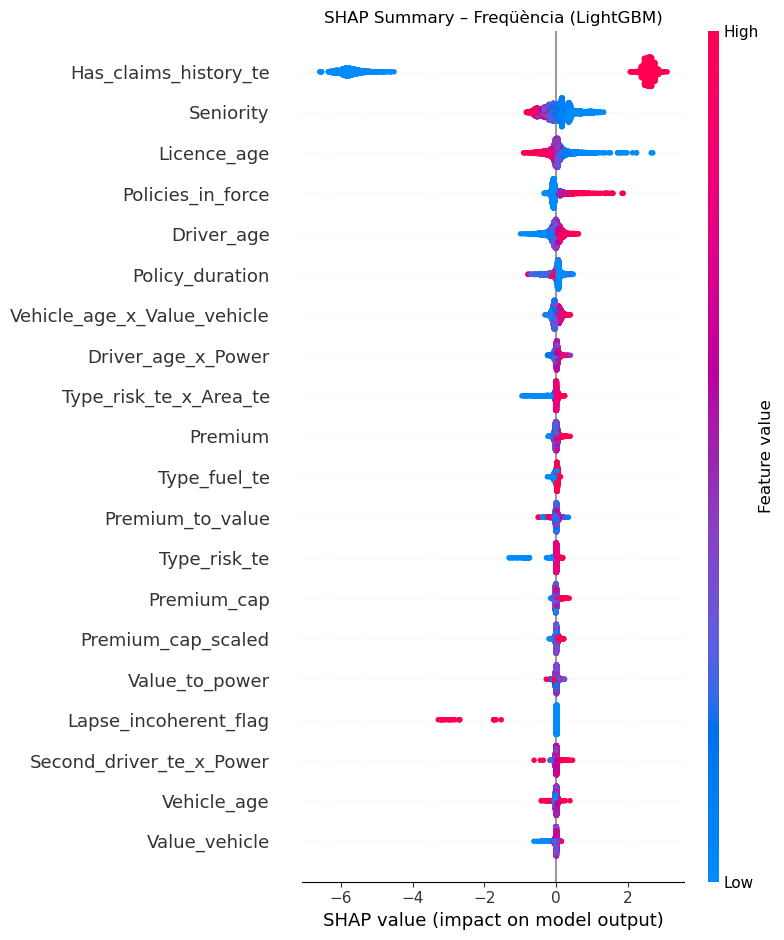

Guardat: data/model\xai\shap_summary_freq.png


<Figure size 700x500 with 0 Axes>

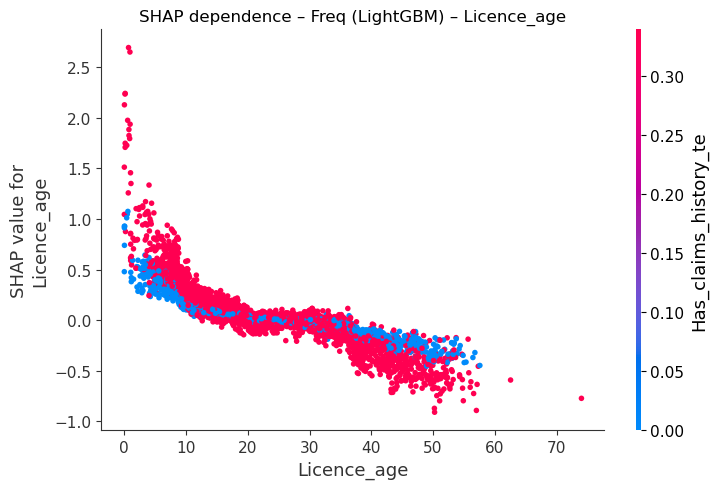

Guardat: data/model\xai\shap_dependence_freq_Licence_age.png


<Figure size 700x500 with 0 Axes>

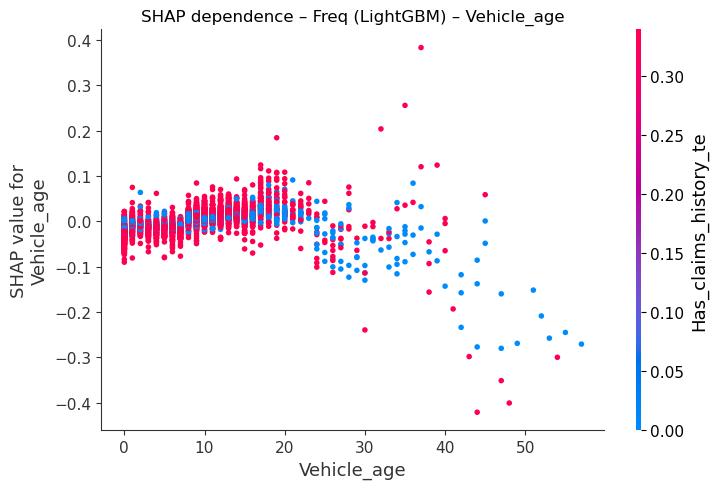

Guardat: data/model\xai\shap_dependence_freq_Vehicle_age.png


<Figure size 700x500 with 0 Axes>

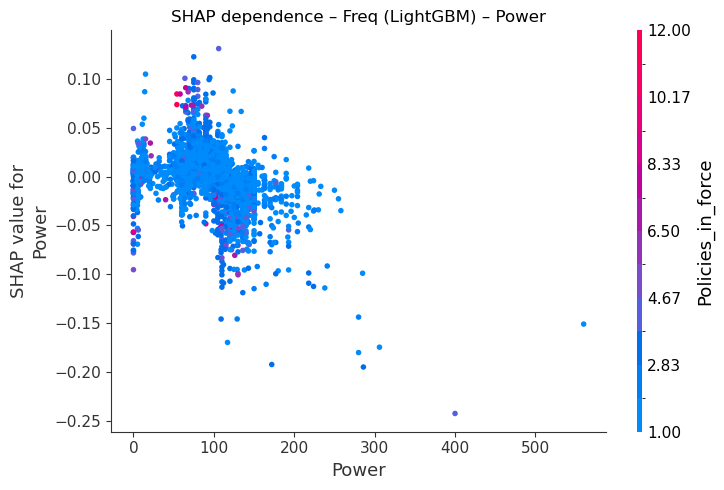

Guardat: data/model\xai\shap_dependence_freq_Power.png


<Figure size 700x500 with 0 Axes>

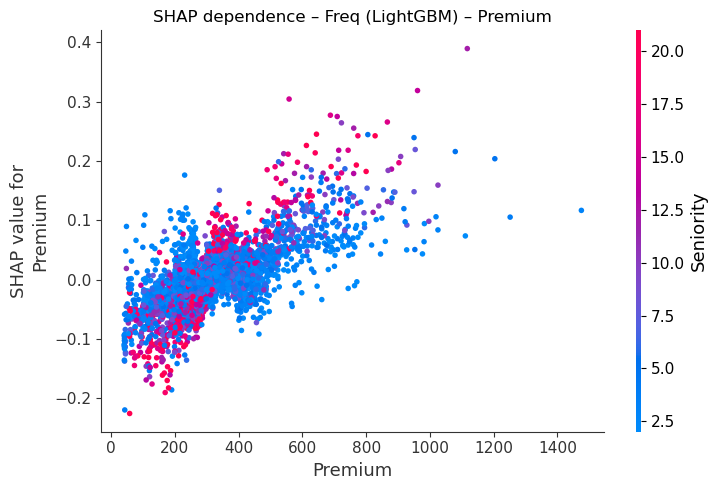

Guardat: data/model\xai\shap_dependence_freq_Premium.png


<Figure size 700x500 with 0 Axes>

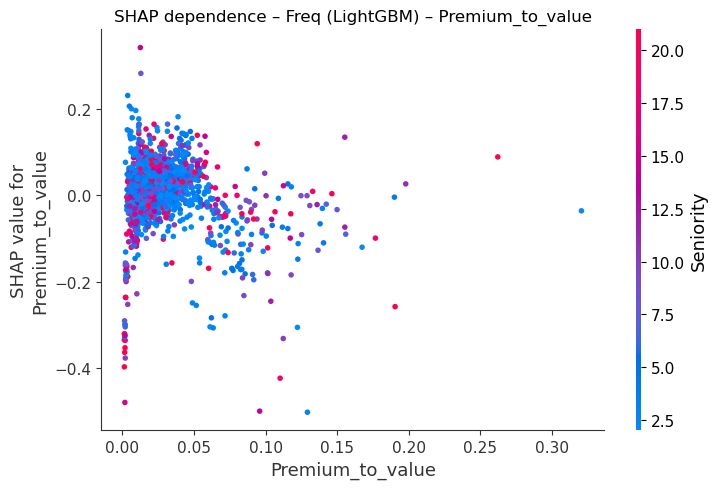

Guardat: data/model\xai\shap_dependence_freq_Premium_to_value.png


<Figure size 700x500 with 0 Axes>

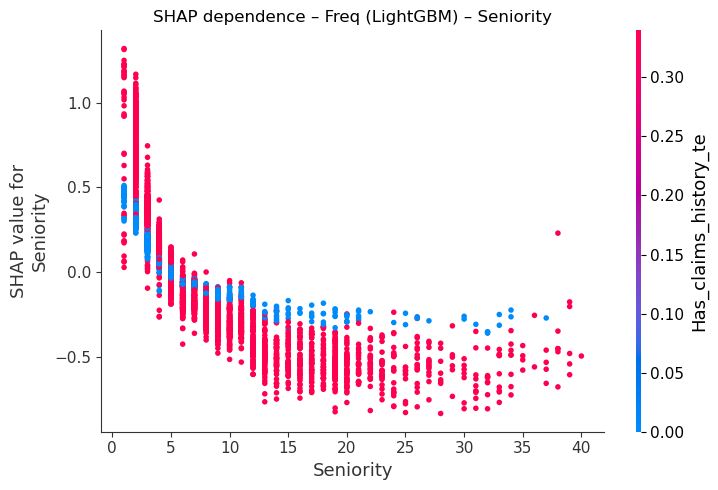

Guardat: data/model\xai\shap_dependence_freq_Seniority.png


<Figure size 700x500 with 0 Axes>

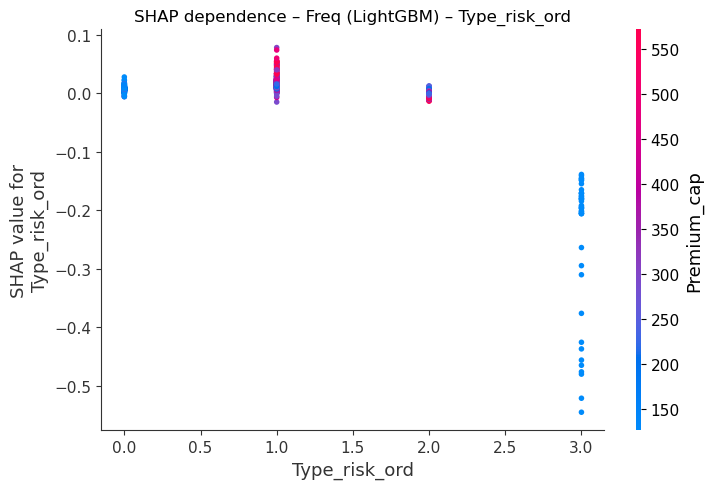

Guardat: data/model\xai\shap_dependence_freq_Type_risk_ord.png

Guardat: data/model\xai\freq_shap_importance.csv
TOP 15 FREQ segons mean(|SHAP|):
                        feature  mean_abs_shap
32        Has_claims_history_te       3.558971
7                     Seniority       0.300319
1                   Licence_age       0.171794
8             Policies_in_force       0.123659
0                    Driver_age       0.111150
3               Policy_duration       0.090310
34  Vehicle_age_x_Value_vehicle       0.074960
33           Driver_age_x_Power       0.040956
37       Type_risk_te_x_Area_te       0.035771
6                       Premium       0.034460
28                 Type_fuel_te       0.030133
36             Premium_to_value       0.027479
26                 Type_risk_te       0.026651
17                  Premium_cap       0.025791
20           Premium_cap_scaled       0.024813


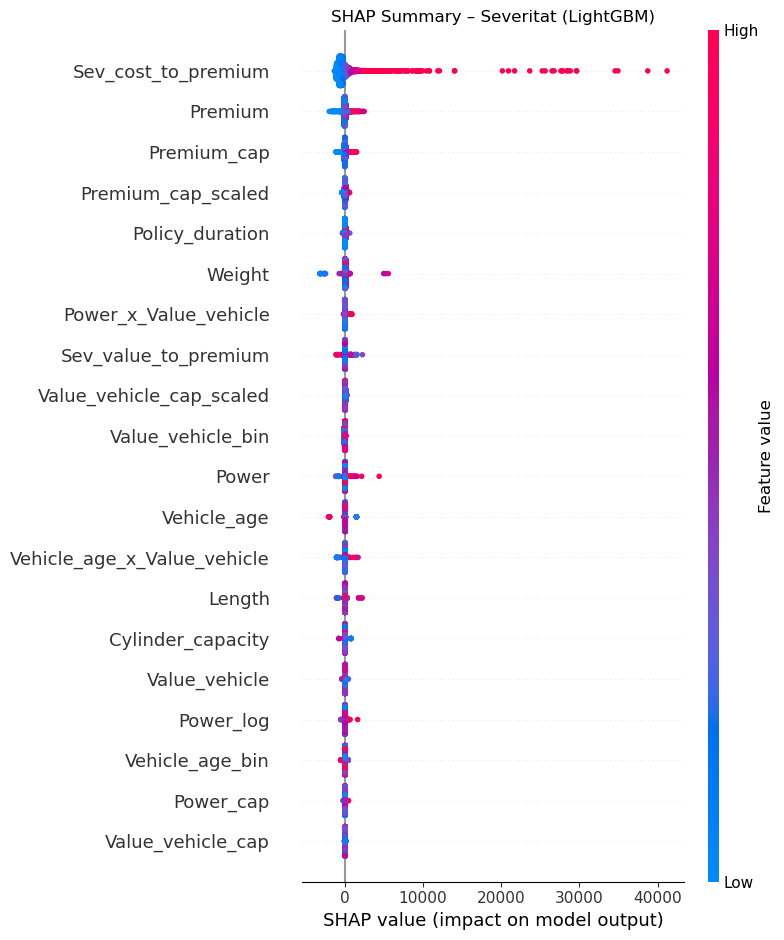

Guardat: data/model\xai\shap_summary_sev.png


<Figure size 700x500 with 0 Axes>

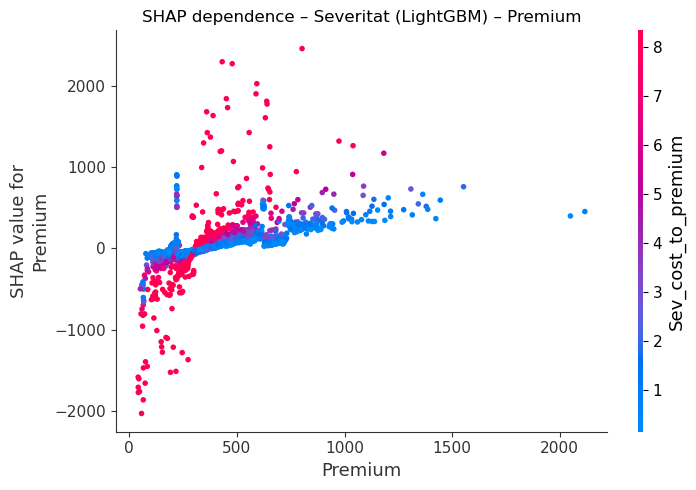

Guardat: data/model\xai\shap_dependence_sev_Premium.png


<Figure size 700x500 with 0 Axes>

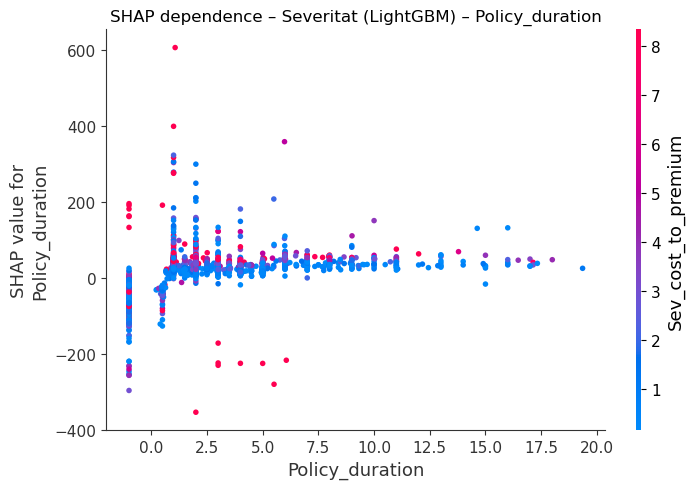

Guardat: data/model\xai\shap_dependence_sev_Policy_duration.png


<Figure size 700x500 with 0 Axes>

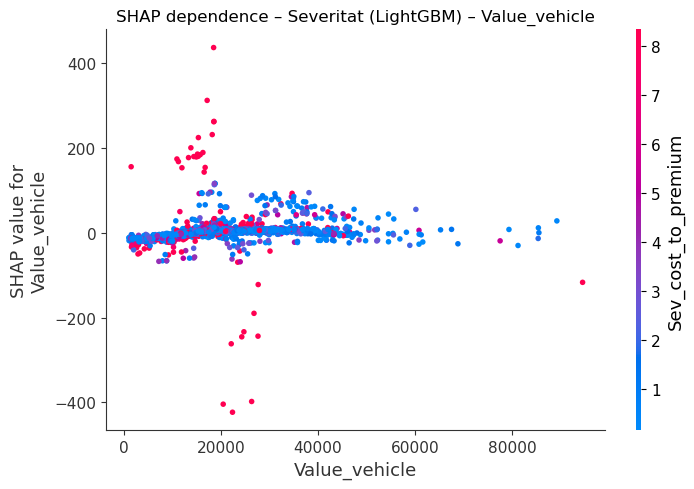

Guardat: data/model\xai\shap_dependence_sev_Value_vehicle.png


<Figure size 700x500 with 0 Axes>

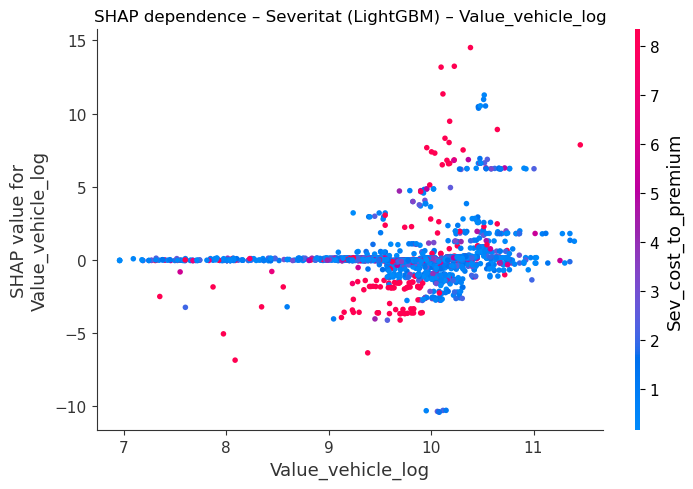

Guardat: data/model\xai\shap_dependence_sev_Value_vehicle_log.png


<Figure size 700x500 with 0 Axes>

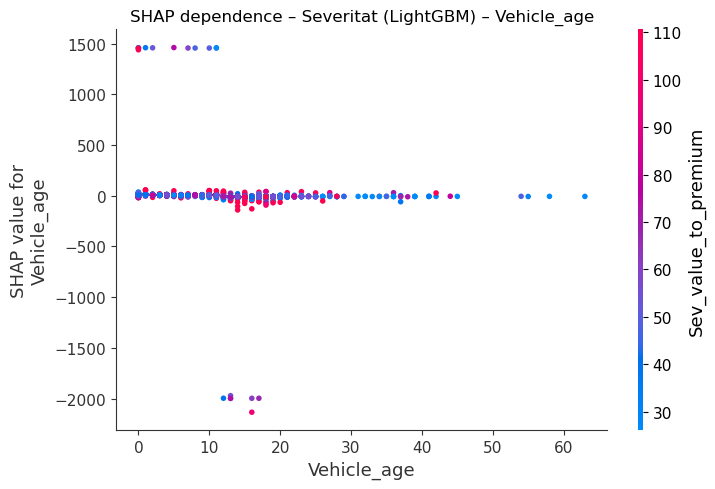

Guardat: data/model\xai\shap_dependence_sev_Vehicle_age.png


<Figure size 700x500 with 0 Axes>

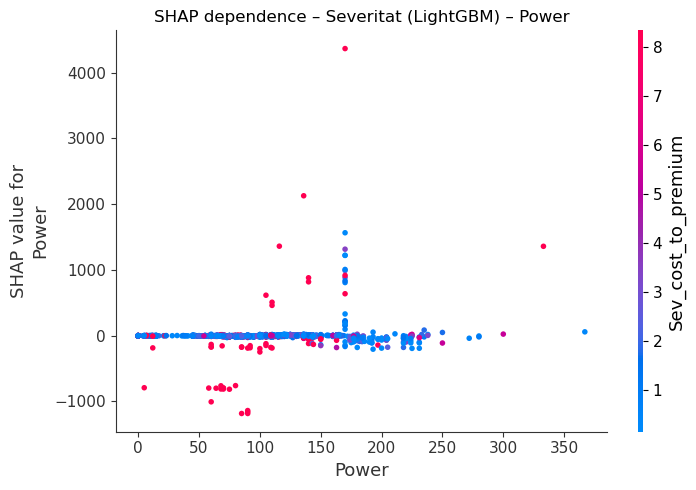

Guardat: data/model\xai\shap_dependence_sev_Power.png


<Figure size 700x500 with 0 Axes>

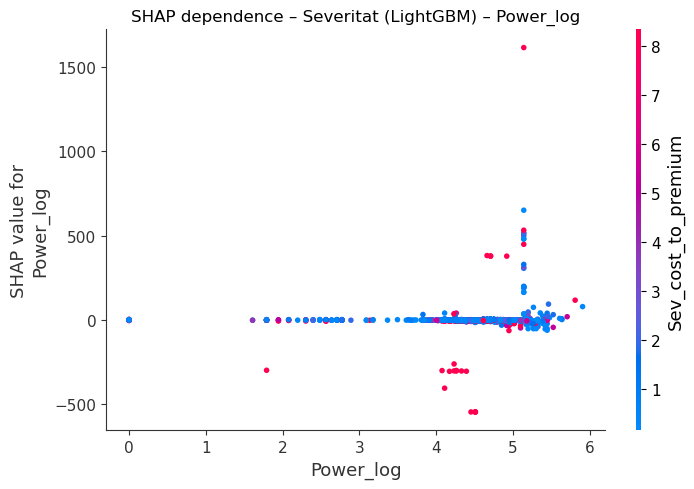

Guardat: data/model\xai\shap_dependence_sev_Power_log.png


<Figure size 700x500 with 0 Axes>

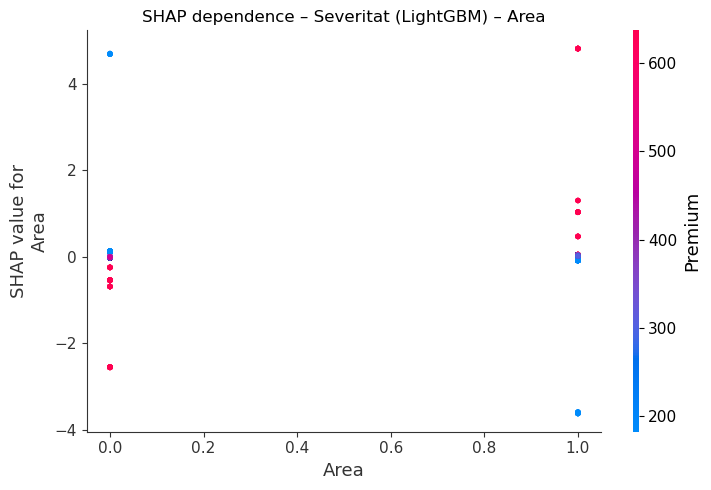

Guardat: data/model\xai\shap_dependence_sev_Area.png

Guardat: data/model\xai\sev_shap_importance.csv
TOP 15 SEV segons mean(|SHAP|):
                        feature  mean_abs_shap
27          Sev_cost_to_premium     842.558612
8                       Premium      92.037717
18                  Premium_cap      87.782680
21           Premium_cap_scaled      50.685569
5               Policy_duration      31.900357
6                        Weight      28.766630
26        Power_x_Value_vehicle      22.686064
28         Sev_value_to_premium      22.543933
19     Value_vehicle_cap_scaled      22.239722
24            Value_vehicle_bin      20.733329
2                         Power      15.088516
0                   Vehicle_age      14.524493
25  Vehicle_age_x_Value_vehicle      13.770761
9                        Length      11.204529
7             Cylinder_capacity       9.161124


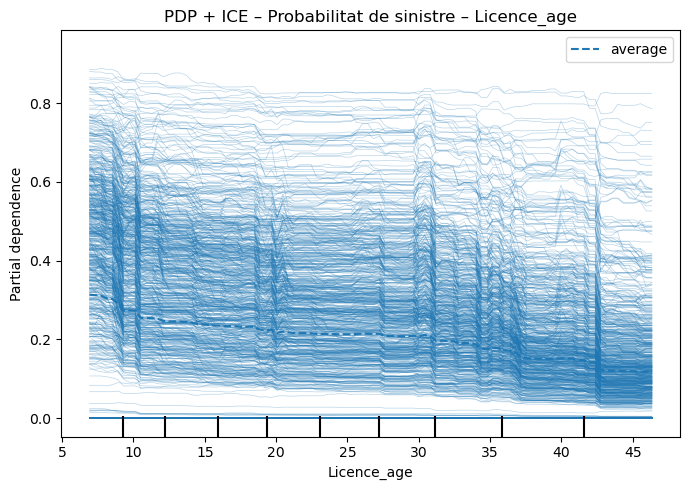

Guardat: data/model\xai\pdp_ice_freq_Licence_age.png


C:\Users\TpM\anaconda3\envs\environment_uoc2025\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 2 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


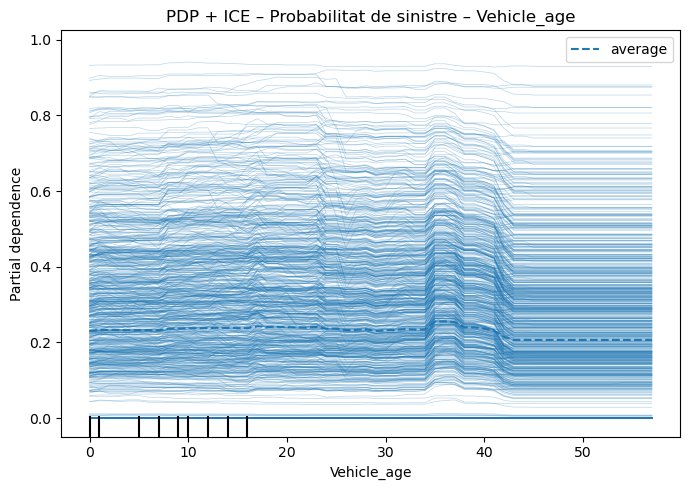

Guardat: data/model\xai\pdp_ice_freq_Vehicle_age.png


C:\Users\TpM\anaconda3\envs\environment_uoc2025\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 5 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


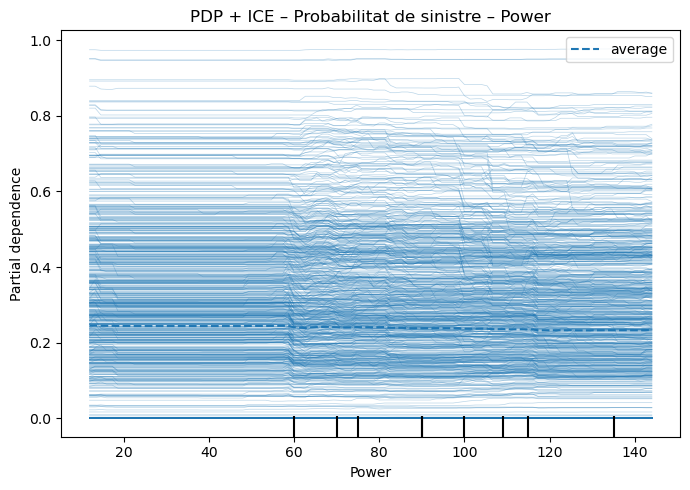

Guardat: data/model\xai\pdp_ice_freq_Power.png


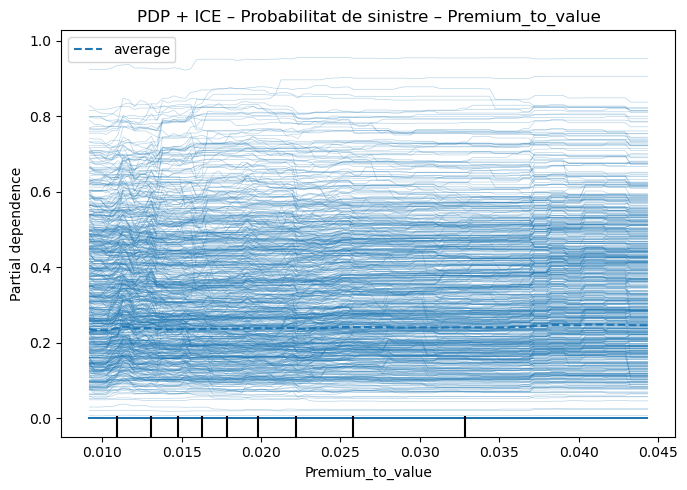

Guardat: data/model\xai\pdp_ice_freq_Premium_to_value.png

LIME – instància test idx=0, y_true=0
Guardat: data/model\xai\lime_freq_instance_0.html

=== LIME (TOP 10) contribucions locals ===
Has_claims_history_te <= 0.00: -0.3540404804102255
Lapse_incoherent_flag <= 0.00: 0.1598680880758451
Licence_age > 33.84: -0.10775733291564756
Driver_age > 53.34: 0.04955632604150331
Policy_incoherent_flag <= 0.00: 0.04929417625479401
Type_risk_ord <= 2.00: 0.04638756116674611
Licence_incoherent_flag <= 0.00: 0.03466788477389842
Policy_duration <= -1.00: 0.030613489020632274
1.00 < Policies_in_force <= 2.00: 0.02587859851977129
Type_risk_te <= 0.24: -0.020462128306270668

3.4.6 complet – XAI generat a: data/model\xai


In [17]:
# =====================================================================
# 3.4.5 INTERPRETABILITAT I EXPLICABILITAT (XAI)
# =====================================================================
# Objectiu:
#   - Aplico tècniques d'interpretabilitat (XAI) sobre els models "champion"
#     no lineals que he triat com a finals:
#       * LightGBM Classifier per a FREQÜÈNCIA
#       * LightGBM Regressor per a SEVERITAT
#
# Què genero aquí:
#   - SHAP:
#       · Summary plot (importància global)
#       · Dependence plots (efectes marginals / possibles interaccions)
#       · Taules d'importància mean(|SHAP|) en CSV
#   - PDP + ICE:
#       · Efecte marginal sobre la probabilitat de sinistre (freq)
#   - LIME:
#       · Explicació local d'una pòlissa concreta del test (freq)
#
# Requisits:
#   - Dono per fet que ja he executat les seccions anteriors (3.4.3 / 3.4.4)
#     on tinc definides:
#       prepare_xy_class_freq, prepare_xy_severity, align_train_test
#
# Nota:
#   - Aquí no busco "millorar" mètriques, sinó entendre què està aprenent el model
#     i poder justificar el comportament al TFM.
# =====================================================================

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn.metrics import roc_auc_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay


# ---------------------------------------------------------------------
# 0) CONFIGURACIÓ GENERAL
# ---------------------------------------------------------------------
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

BASE_MODEL_PATH = "data/model"

# Aquí és on em guardaré tots els outputs XAI (PNG/CSV/HTML)
XAI_OUT_DIR = os.path.join(BASE_MODEL_PATH, "xai")
os.makedirs(XAI_OUT_DIR, exist_ok=True)

# Em trec warnings molestos que poden aparèixer amb SHAP/LightGBM (si surten)
warnings.filterwarnings(
    "ignore",
    message="LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray"
)


# ---------------------------------------------------------------------
# 1) IMPORT OPCIONAL DE SHAP I LIME
# ---------------------------------------------------------------------
# Ho importo de forma opcional perquè vull que el script segueixi funcionant
# encara que el meu entorn no tingui aquestes llibreries instal·lades.
try:
    import shap
    SHAP_AVAILABLE = True

    # initjs() és útil en notebooks per visualitzacions interactives,
    # però si no renderitza no passa res (per això el try/except).
    try:
        shap.initjs()
    except Exception:
        pass

except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP no disponible → ometo tota l'anàlisi SHAP.")

try:
    from lime.lime_tabular import LimeTabularExplainer
    LIME_AVAILABLE = True
except ImportError:
    LIME_AVAILABLE = False
    print("LIME no disponible → ometo les explicacions LIME.")


# ---------------------------------------------------------------------
# 2) COMPROVACIÓ DE FUNCIONS AUXILIARS (de seccions anteriors)
# ---------------------------------------------------------------------
# Si no tinc les funcions de preparació i alineació, aquí no puc fer XAI amb garanties.
required_funcs = ["prepare_xy_class_freq", "prepare_xy_severity", "align_train_test"]
for fname in required_funcs:
    if fname not in globals():
        raise RuntimeError(
            f"La funció '{fname}' no està definida. "
            "He d'executar abans les seccions on defineixo prepare_xy_* i align_train_test."
        )

# M'asseguro de treballar amb les mateixes referències que hi ha al notebook
prepare_xy_class_freq = globals()["prepare_xy_class_freq"]
prepare_xy_severity   = globals()["prepare_xy_severity"]
align_train_test      = globals()["align_train_test"]


# ---------------------------------------------------------------------
# 3) CÀRREGA DE DADES
# ---------------------------------------------------------------------
# Carrego datasets de freq (full engineered) i de severitat, tant train com test.
FREQ_GBM_TRAIN_PATH = os.path.join(BASE_MODEL_PATH, "freq_gbm_train.csv")
FREQ_GBM_TEST_PATH  = os.path.join(BASE_MODEL_PATH, "freq_gbm_test.csv")
SEV_TRAIN_PATH      = os.path.join(BASE_MODEL_PATH, "sev_train.csv")
SEV_TEST_PATH       = os.path.join(BASE_MODEL_PATH, "sev_test.csv")

freq_gbm_train = pd.read_csv(FREQ_GBM_TRAIN_PATH)
freq_gbm_test  = pd.read_csv(FREQ_GBM_TEST_PATH)
sev_train      = pd.read_csv(SEV_TRAIN_PATH)
sev_test       = pd.read_csv(SEV_TEST_PATH)


# ---------------------------------------------------------------------
# 4) PREPARACIÓ DE X, y (mateixa lògica anti-leakage)
# ---------------------------------------------------------------------
# Aquí reutilitzo les funcions de preparació per mantenir criteri consistent
# amb el que he fet a 3.4.3 / 3.4.4.

# 4.1 FREQÜÈNCIA
X_train_freq_raw, y_train_freq = prepare_xy_class_freq(freq_gbm_train, target="Has_claims_year")
X_test_freq_raw,  y_test_freq  = prepare_xy_class_freq(freq_gbm_test,  target="Has_claims_year")

# Alineo columnes perquè train i test tinguin exactament els mateixos predictors (mateix ordre inclòs)
X_train_freq, X_test_freq = align_train_test(X_train_freq_raw, X_test_freq_raw)

print("Shape FREQ (train X,y):", X_train_freq.shape, y_train_freq.shape)
print("Shape FREQ (test  X,y):", X_test_freq.shape,  y_test_freq.shape)

# 4.2 SEVERITAT
X_train_sev_raw, y_train_sev = prepare_xy_severity(sev_train, target="Cost_claims_year")
X_test_sev_raw,  y_test_sev  = prepare_xy_severity(sev_test,  target="Cost_claims_year")

X_train_sev, X_test_sev = align_train_test(X_train_sev_raw, X_test_sev_raw)

print("Shape SEV  (train X,y):", X_train_sev.shape, y_train_sev.shape)
print("Shape SEV  (test  X,y):", X_test_sev.shape,  y_test_sev.shape)

# Sanitització extra del target de severitat:
#   - No és que m'ho esperi, però em cobreixo davant NaN/Inf i possibles valors <= 0.
y_train_sev = pd.Series(y_train_sev).replace([np.inf, -np.inf], np.nan)
y_test_sev  = pd.Series(y_test_sev).replace([np.inf, -np.inf], np.nan)

y_train_sev = y_train_sev.fillna(y_train_sev.median())
y_test_sev  = y_test_sev.fillna(y_test_sev.median())

# Si en algun moment aparegués algun valor <= 0, faig un clip suau per evitar problemes numèrics.
if (y_train_sev <= 0).any():
    y_train_sev = y_train_sev.clip(lower=1e-6)
if (y_test_sev <= 0).any():
    y_test_sev = y_test_sev.clip(lower=1e-6)


# ---------------------------------------------------------------------
# 5) ENTRENAMENT DELS MODELS "CHAMPION" (LightGBM)
# ---------------------------------------------------------------------
# Aquí torno a entrenar els champions sobre el train, amb els hiperparàmetres
# que ja he fixat abans. És necessari perquè després pugui calcular SHAP/PDP/LIME
# sobre el model entrenat i sobre les mateixes features.

# 5.1 Freqüència (Classifier)
lgbm_freq = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.02,
    max_depth=-1,
    num_leaves=63,
    subsample=1.0,
    colsample_bytree=0.8,
    objective="binary",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
lgbm_freq.fit(X_train_freq, y_train_freq)

# Faig un check ràpid d'AUC per assegurar que el model està "com toca"
y_proba_test = lgbm_freq.predict_proba(X_test_freq)[:, 1]
auc_test = roc_auc_score(y_test_freq, y_proba_test)
print(f"AUC LightGBM FREQ (test 2018): {auc_test:.6f}")

# 5.2 Severitat (Regressor)
lgbm_sev = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.02,
    max_depth=5,
    num_leaves=127,
    subsample=0.7,
    colsample_bytree=0.7,
    objective="regression",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
lgbm_sev.fit(X_train_sev, y_train_sev)

# També faig mètriques bàsiques per tenir control que no estic interpretant un model "trencat"
y_pred_sev = lgbm_sev.predict(X_test_sev)
mae_sev  = mean_absolute_error(y_test_sev, y_pred_sev)
rmse_sev = float(np.sqrt(mean_squared_error(y_test_sev, y_pred_sev)))
r2_sev   = r2_score(y_test_sev, y_pred_sev)

print(f"SEVERITAT LightGBM – MAE={mae_sev:.6f}, RMSE={rmse_sev:.6f}, R²={r2_sev:.6f}")


# ---------------------------------------------------------------------
# 6) SHAP — importància global i dependence plots
# ---------------------------------------------------------------------
if SHAP_AVAILABLE:
    # Per no convertir això en un procés etern, faig servir una mostra de train.
    # El 5000 és un valor típic; si el PC va lent, el puc baixar.
    n_shap = min(5000, len(X_train_freq))
    freq_sample = X_train_freq.sample(n=n_shap, random_state=RANDOM_STATE)

    # ---------- 6.1 SHAP FREQ ----------
    # TreeExplainer és el més apropiat per LightGBM.
    explainer_freq = shap.TreeExplainer(lgbm_freq)
    shap_values_freq = explainer_freq.shap_values(freq_sample)

    # En classificació binària, de vegades SHAP retorna [classe0, classe1].
    # Jo em quedo amb la classe 1 (sinistre).
    if isinstance(shap_values_freq, list) and len(shap_values_freq) == 2:
        shap_values_freq_1 = shap_values_freq[1]
    else:
        shap_values_freq_1 = shap_values_freq

    # Summary plot (importància global) i el guardo a PNG
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_freq_1, freq_sample, show=False)
    plt.title("SHAP Summary – Freqüència (LightGBM)")
    plt.tight_layout()
    out_path = os.path.join(XAI_OUT_DIR, "shap_summary_freq.png")
    plt.savefig(out_path, dpi=200)
    plt.show()
    print("Guardat:", out_path)

    # Dependence plots:
    # Primer provo una llista de variables "candidates" típics que m'interessa veure.
    # Si cap existeix, faig un fallback defensable: TOP-3 per mean(|SHAP|).
    candidate_features_freq = [
        "Licence_age", "Vehicle_age", "Power", "Premium", "Premium_to_value",
        "Seniority", "Type_risk_ord"
    ]
    freq_features_for_dep = [f for f in candidate_features_freq if f in freq_sample.columns]

    if not freq_features_for_dep:
        mean_abs = np.mean(np.abs(shap_values_freq_1), axis=0)
        top_idx = np.argsort(mean_abs)[::-1][:3]
        freq_features_for_dep = [freq_sample.columns[i] for i in top_idx]

    for feat in freq_features_for_dep:
        plt.figure(figsize=(7, 5))
        shap.dependence_plot(
            feat,
            shap_values_freq_1,
            freq_sample,
            show=False
        )
        plt.title(f"SHAP dependence – Freq (LightGBM) – {feat}")
        plt.tight_layout()
        out_path = os.path.join(XAI_OUT_DIR, f"shap_dependence_freq_{feat}.png")
        plt.savefig(out_path, dpi=200)
        plt.show()
        print("Guardat:", out_path)

    # Taula d'importància global (mean(|SHAP|)) per freq
    mean_abs_shap_freq = np.mean(np.abs(shap_values_freq_1), axis=0)
    freq_shap_importance = pd.DataFrame({
        "feature": freq_sample.columns,
        "mean_abs_shap": mean_abs_shap_freq,
    }).sort_values("mean_abs_shap", ascending=False)

    out_csv = os.path.join(XAI_OUT_DIR, "freq_shap_importance.csv")
    freq_shap_importance.to_csv(out_csv, index=False)
    print("\nGuardat:", out_csv)
    print("TOP 15 FREQ segons mean(|SHAP|):")
    print(freq_shap_importance.head(15))

    # ---------- 6.2 SHAP SEV ----------
    n_shap_sev = min(5000, len(X_train_sev))
    sev_sample = X_train_sev.sample(n=n_shap_sev, random_state=RANDOM_STATE)

    explainer_sev = shap.TreeExplainer(lgbm_sev)
    shap_values_sev = explainer_sev.shap_values(sev_sample)

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_sev, sev_sample, show=False)
    plt.title("SHAP Summary – Severitat (LightGBM)")
    plt.tight_layout()
    out_path = os.path.join(XAI_OUT_DIR, "shap_summary_sev.png")
    plt.savefig(out_path, dpi=200)
    plt.show()
    print("Guardat:", out_path)

    candidate_features_sev = [
        "Premium", "Policy_duration", "Value_vehicle", "Value_vehicle_log",
        "Vehicle_age", "Power", "Power_log", "Area"
    ]
    sev_features_for_dep = [f for f in candidate_features_sev if f in sev_sample.columns]

    if not sev_features_for_dep:
        mean_abs = np.mean(np.abs(shap_values_sev), axis=0)
        top_idx = np.argsort(mean_abs)[::-1][:3]
        sev_features_for_dep = [sev_sample.columns[i] for i in top_idx]

    for feat in sev_features_for_dep:
        plt.figure(figsize=(7, 5))
        shap.dependence_plot(
            feat,
            shap_values_sev,
            sev_sample,
            show=False
        )
        plt.title(f"SHAP dependence – Severitat (LightGBM) – {feat}")
        plt.tight_layout()
        out_path = os.path.join(XAI_OUT_DIR, f"shap_dependence_sev_{feat}.png")
        plt.savefig(out_path, dpi=200)
        plt.show()
        print("Guardat:", out_path)

    # Taula d'importància global (mean(|SHAP|)) per severitat
    mean_abs_shap_sev = np.mean(np.abs(shap_values_sev), axis=0)
    sev_shap_importance = pd.DataFrame({
        "feature": sev_sample.columns,
        "mean_abs_shap": mean_abs_shap_sev,
    }).sort_values("mean_abs_shap", ascending=False)

    out_csv = os.path.join(XAI_OUT_DIR, "sev_shap_importance.csv")
    sev_shap_importance.to_csv(out_csv, index=False)
    print("\nGuardat:", out_csv)
    print("TOP 15 SEV segons mean(|SHAP|):")
    print(sev_shap_importance.head(15))


# ---------------------------------------------------------------------
# 7) PDP + ICE (Freqüència)
# ---------------------------------------------------------------------
# Nota:
#   - Vull veure l'efecte marginal sobre la probabilitat de sinistre (classe 1).
#   - Depenent de la versió d'Scikit-learn, response_method/target poden variar,
#     així que ho gestiono amb try/except per no quedar-me tirat.
X_pdp_sample = X_train_freq.sample(n=min(5000, len(X_train_freq)), random_state=RANDOM_STATE)

# Trio variables "interpretables" i, si no existeixen, faig un fallback perquè sempre pugui dibuixar alguna cosa.
candidate_pdp_features = ["Licence_age", "Vehicle_age", "Power", "Premium_to_value", "Seniority"]
pdp_features = [f for f in candidate_pdp_features if f in X_pdp_sample.columns]

if not pdp_features:
    # Fallback molt simple: agafo les dues primeres columnes (no és ideal, però evita errors)
    pdp_features = X_pdp_sample.columns[:2].tolist()

# Limito a 4 figures per no omplir-ho tot de PNGs
for feat in pdp_features[:4]:
    fig, ax = plt.subplots(figsize=(7, 5))
    try:
        PartialDependenceDisplay.from_estimator(
            estimator=lgbm_freq,
            X=X_pdp_sample,
            features=[feat],
            kind="both",                 # PDP + ICE
            response_method="predict_proba",
            target=1,
            ax=ax,
        )
    except TypeError:
        # Fallback per versions que no suporten response_method/target
        PartialDependenceDisplay.from_estimator(
            estimator=lgbm_freq,
            X=X_pdp_sample,
            features=[feat],
            kind="both",
            ax=ax,
        )

    plt.title(f"PDP + ICE – Probabilitat de sinistre – {feat}")
    plt.tight_layout()
    out_path = os.path.join(XAI_OUT_DIR, f"pdp_ice_freq_{feat}.png")
    plt.savefig(out_path, dpi=200)
    plt.show()
    print("Guardat:", out_path)


# ---------------------------------------------------------------------
# 8) LIME (Freqüència) — explicació local
# ---------------------------------------------------------------------
if LIME_AVAILABLE:
    # Wrapper perquè LIME em passa arrays i el model espera DataFrame amb noms de columnes.
    def lgbm_predict_proba(X_arr: np.ndarray) -> np.ndarray:
        X_df = pd.DataFrame(X_arr, columns=X_train_freq.columns)
        # LIME espera un output (n_samples, 2) amb probabilitats per classe
        return lgbm_freq.predict_proba(X_df)

    # Creo l'explainer amb el train (és el que LIME fa servir per discretitzar i generar perturbarions)
    lime_explainer = LimeTabularExplainer(
        training_data=X_train_freq.values,
        feature_names=X_train_freq.columns.tolist(),
        class_names=["no_claim", "claim"],
        mode="classification",
        discretize_continuous=True,
        random_state=RANDOM_STATE
    )

    # Explico una instància concreta del test.
    # Ara mateix faig idx=0 per defecte; si vull un cas interessant, el canvio.
    instance_idx = 0
    if instance_idx < 0 or instance_idx >= len(X_test_freq):
        raise ValueError("instance_idx fora de rang del test.")

    x_instance = X_test_freq.iloc[instance_idx].values
    y_true_instance = int(y_test_freq.iloc[instance_idx])

    print(f"\nLIME – instància test idx={instance_idx}, y_true={y_true_instance}")

    lime_exp = lime_explainer.explain_instance(
        data_row=x_instance,
        predict_fn=lgbm_predict_proba,
        num_features=10,
    )

    # El guardo a HTML perquè va molt bé per annexos del TFM (i queda visual)
    out_html = os.path.join(XAI_OUT_DIR, f"lime_freq_instance_{instance_idx}.html")
    lime_exp.save_to_file(out_html)
    print("Guardat:", out_html)

    # També imprimeixo el resum per consola per tenir-ho ràpid quan escric conclusions
    print("\n=== LIME (TOP 10) contribucions locals ===")
    for feat, contrib in lime_exp.as_list():
        print(f"{feat}: {contrib}")


print("\n3.4.5 complet – XAI generat a:", XAI_OUT_DIR)
